In [6]:
import rep
%pip install catboost
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from catboost import CatBoostClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import (accuracy_score, roc_auc_score, log_loss,
                             confusion_matrix, classification_report, precision_recall_curve,
                             auc, f1_score, precision_score, recall_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
from scipy import stats


C:\Users\muril\Documents\scrapper\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
warnings.filterwarnings('ignore')

print("= " * 60)
print("MODELO DE PREVISÃO NBA COM OPTUNA OPTIMIZATION")
print("=" * 60)

SEED = 42
np.random.seed(SEED)
import random

random.seed(SEED)


= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
MODELO DE PREVISÃO NBA COM OPTUNA OPTIMIZATION


In [9]:
#pra n ficar vazando dados, aqui calcula uma data "segura" que eh o atual menos o buffer, e retorna as linhas com a data menor que essa.
#Tudo isso pra nao usar os jogos ocorridos no mesmo dia ou dps
#aqui eh tipo uma "utils"
def safe_temporal_filter(df, current_date, buffer_days=1):
      #ain mestre oque é buffer? qts dias pra tras vc quer parar de olhar filho... se hoje é 13 de outubro (parabens pra mim) e buffer_days = 1, logo vazmos usar dados ate o dia 12 de outubro. Ou seja o modelo so enxerga jogos passados filhão...
    safe_date = current_date - timedelta(days=buffer_days)
    return df[df['date'] < safe_date]

#So pra calcular a media ponderada, quanto mais pesado o item mais vai influenciar o resultado, isso eh pra dar importancia pra jogos mais recentes
#se um jogo recente tem peso 0.8 e um antigo 0.2, o recente “manda” mais no resultado
def wavg(values, weights):
    values = np.asarray(values, dtype=float)
    weights = np.asarray(weights, dtype=float)
    if len(values) == 0 or len(weights) == 0:
        return 0.0
    return float(np.average(values, weights=weights))


#dp ponderado, medir volatilidade.
#serve pra avaliar se o time está consistente ou muito irregular
def wstd(values, weights):
    values = np.asarray(values, dtype=float)
    weights = np.asarray(weights, dtype=float)
    if len(values) == 0 or len(weights) == 0:
        return 0.0
    m = np.average(values, weights=weights)#variância ponderada = média ponderada dos quadrados dos desvio
    var = np.average((values - m) ** 2, weights=weights)#desvio padrão ponderado = raiz quadrada da variância ponderada isso eh estatistica filho
    return float(np.sqrt(var))

# criar o peso para cada jogo, -> jogo recente tem mais peso -> se o time ta instavel (alta volatilidade) os jogos antigos meio que perdem a importancia
# aqui eh daora pq se um jogo eh tipo um classico ele ganha um peso extra kkk
def calculate_dynamic_weights(dates, ref_date, volatility=None, game_importance=None):
    days_ago = (ref_date - dates).dt.days.clip(lower=0)

    if volatility is not None:
        lambda_param = 0.05 * (1 + volatility / 10) # quanto maior a volatividade mais rapido o modelo precisa esquecer os jogos antigos... quanto menor mais ok são
    else:
        lambda_param = 0.05

    weights = np.exp(-lambda_param * days_ago)

    if game_importance is not None:
        weights *= (1 + 0.2 * np.array(game_importance))# isso aqui eh pra classico nao fiz ainda, mas dependendo da importancia do jogo ele multiplica o peso de cada jogo por (1 + 0.2 × importancia).

    if weights.sum() > 0:
        weights = weights / weights.sum() # dps  de aplicar todos os ajustes ele normaliza tudo pra somar 1 ai ngm fica com um peso exagerado mais de cinco dedera dourada duro dorme ja diz o ditado

    return weights

# aqui eh usando heuristica pra ter um intervalo de confiança, se tem menos dados vai aumentar a incerteza, instabilidade do time tb
def calculate_confidence_interval(predictions, features, model_type='catboost'):
    base_pred = predictions # privisao og do modelo
    uncertainty_factors = []# uma lista pra acumular parada pra "desconfiar" do nosso modelo

    if 'actual_window' in features:
        if features['actual_window'] < 8:  # se o modelo usou menos de 8 jogos pra calcular a média ele nao tem TANTA base estatistica ai add 15% de incerteza
            uncertainty_factors.append(0.15)

    if 'home_score_volatility' in features and 'visitor_score_volatility' in features:
        avg_vol = (features['home_score_volatility'] + features['visitor_score_volatility']) / 2
        if avg_vol > 15:#se as pontuações dos dois times variam muito volatilidade (lembra dela) maior que 15, significa que os resultados sao ?? imprevisiveis add ai mais 10% de incerteza
            uncertainty_factors.append(0.10) #times que ganham de 130–80 e depois perdem de 85–110 sao muito incosistentes concorda? logo o modelo vai sofrer tadinho

    if 'days_into_season' in features:
        if features['days_into_season'] < 30: # se ainda estamos no começo da temporada eh mto cedo, joga mais 10% ai
            uncertainty_factors.append(0.10)

    base_margin = 0.05# msm sem nada disso add 5%, ainnn mestre pq? nenhum modelo é 100% certo ne bb, mesmo nas melhores condições melhor errar aqui doq ser um mala do crlh e zoar o modelo
    total_margin = base_margin + sum(uncertainty_factors) # soma todas as "penalidades"

    lower_bound = max(0, base_pred - total_margin)#define os limites do intervalo de confiança, garantindo que fiquem entre 0 e 1
    upper_bound = min(1, base_pred + total_margin) # aqui eh o score de confiança que a gente tira o 1 (100% faltou nas aulas de estatistica?) com as penalidades somadas
    confidence_score = 1 - total_margin

    return lower_bound, upper_bound, confidence_score


class TemporalValidator:
    def __init__(self, n_splits=3, embargo_days=1, min_train=50, min_test=10):
        self.n_splits = n_splits
        self.embargo_days = embargo_days
        self.min_train = min_train
        self.min_test = min_test


    def split(self, df):
        if 'date' not in df.columns or len(df) == 0:
            return []

        # ordena os dados por data
        df_sorted = df.sort_values('date').reset_index(drop=True)
        # normaliza as datas para remover hora/minuto/segundo
        date_norm = df_sorted['date'].dt.normalize()
        # extrai os dias unicos n pode duplicar
        unique_days = date_norm.unique()

        # precisa ter pelo menos n_splits + 2 dias únicos para criar folds
        if len(unique_days) < self.n_splits + 2:
            return []

        # tamanho medio de cada fold em número de dias
        fold_len = max(1, len(unique_days) // (self.n_splits + 1))
        splits = []

        # loop para gerar os folds de trás pra frente (do mais recente pro mais antigo)
        for i in range(self.n_splits):
        # define o início e o fim do conjunto de teste em termos de índice no vetor de dias únicos
            test_start_idx = len(unique_days) - (i + 1) * fold_len
            test_end_idx = len(unique_days) - 1 - i * fold_len

            if test_start_idx < 0 or test_end_idx < 0:
                continue

            # converte os índices em datas reais
            test_start_day = pd.to_datetime(unique_days[test_start_idx])
            test_end_day = pd.to_datetime(unique_days[test_end_idx])
            # calcula a data de corte de embargo
            embargo_cut = test_start_day - pd.Timedelta(days=self.embargo_days)


            # conjunto de treino: tudo antes do embargo
            train_idx = df_sorted[df_sorted['date'] < embargo_cut].index
            # conjunto de teste: tudo dentro do intervalo de teste
            test_idx = df_sorted[
                (df_sorted['date'] >= test_start_day) &
                (df_sorted['date'] <= test_end_day)
                ].index

            if len(train_idx) >= self.min_train and len(test_idx) >= self.min_test:
                splits.append((train_idx.tolist(), test_idx.tolist()))

        return splits


In [10]:
def advanced_adaptive_otw(team_data, current_date, team_name, df_players=None):
    # configs basicas da janela: base (padrão), mínimo e máximo pra não ficar doideira
    BASE_WINDOW = 10
    MIN_WINDOW = 5
    MAX_WINDOW = 20

    # se tem menos jogos que o mínimo, usa tudo que tem e segue
    if len(team_data) < MIN_WINDOW:
        return len(team_data)

    # ponto de início da temporada da nba ~ outubro; se ainda estamos antes de junho, a temporada começou no ano anterior
    season_start = pd.to_datetime(f'{current_date.year}-10-01', utc=True)
    if current_date.month < 6:
        season_start = pd.to_datetime(f'{current_date.year - 1}-10-01', utc=True)

    # quantos dias já rodaram na temporada, isso vai guiar o tamanho da janela
    days_into_season = (current_date - season_start).days

    # degraus simples: começo da temporada usa janela menor, fim da temporada usa algo moderado, meio do caminho usa base
    if days_into_season < 30:
        window = max(MIN_WINDOW, min(len(team_data), 8))
    elif days_into_season > 150:
        window = min(MAX_WINDOW, 15)
    else:
        window = BASE_WINDOW

    # ajuste por estabilidade do time via net_rating: coeficiente de variação manda reduzir/aumentar janela
    if len(team_data) >= 10:
        recent_games = team_data.tail(10)
        if 'net_rating' in recent_games.columns:
            recent_std = recent_games['net_rating'].std()
            recent_mean = abs(recent_games['net_rating'].mean())

            # se a média não é zero, calcula cv(nao eh o comando vermelho) cv alto = instável -> encurta janela, cv baixo = estável -> alonga
            if recent_mean > 0:
                cv = recent_std / recent_mean
                if cv > 1.5:
                    window = max(MIN_WINDOW, window - 3)
                elif cv < 0.5:
                    window = min(MAX_WINDOW, window + 2)

    # se detectou mudança relevante no elenco (lesão/troca), corta agressivo pra reagir rápido
    if df_players is not None:
        roster_change_detected = detect_roster_change(
            df_players, team_name, current_date, lookback_days=14
        )
        if roster_change_detected:
            window = MIN_WINDOW

    # ritmo recente: se jogou muito na última semana, diminui janela, se quase não jogou, aumenta
    games_last_week = team_data[
        team_data['date'] >= (current_date - timedelta(days=7))
    ].shape[0]

    if games_last_week >= 4:
        window = max(MIN_WINDOW, window - 2)
    elif games_last_week <= 1:
        window = min(MAX_WINDOW, window + 2)

    # detecção de mudança de regime: compara média recente com histórica próxima, diferença grande -> encurta
    if len(team_data) >= window + 5:
        recent = team_data.tail(window)
        historical = team_data.tail(window * 2).head(window)

        if 'net_rating' in team_data.columns:
            recent_perf = recent['net_rating'].mean()
            hist_perf = historical['net_rating'].mean()

            if abs(recent_perf - hist_perf) > 10:
                window = max(MIN_WINDOW, window - 2)

    # garante inteiro bonitinho
    return int(window)


def advanced_adaptive_otw_step_optimized(team_data, current_date, team_name, df_players=None):

    # sem jogos, devolve 1 só pra não quebrar nada
    if len(team_data) == 0:
        return 1

    # dias de temporada baseado no início em outubro (ajuste se ainda for antes de junho)
    season_start = pd.to_datetime(f'{current_date.year}-10-01', utc=True)
    if current_date.month < 6:
        season_start = pd.to_datetime(f'{current_date.year - 1}-10-01', utc=True)
    days_into_season = max(0, (current_date - season_start).days)

    # degraus calibrados: menor no início (volatilidade alta), sobe no meio, estabiliza sem exagerar no fim
    if days_into_season <= 30:
        window = 10  # reduzido de 12 pra reagir mais rápido no começo
    elif days_into_season <= 90:  # antes 120
        window = 25  # um pouco menor que 30 pra evitar acumular muito ruído
    elif days_into_season <= 180:  # antes 200
        window = 50  # reduzido de 60 pra dar mais responsividade
    else:
        window = 80  # reduzido de 90 pra não overfitar com cauda muito longa

    # ajuste dinâmico por estabilidade recente via cv do net_rating (janela curta de 12 jogos)
    if 'net_rating' in team_data.columns and len(team_data) >= 8:
        recent = team_data.tail(12)
        nr = recent['net_rating'].astype(float)
        if len(nr) >= 4:
            cv = nr.std() / (abs(nr.mean()) + 1e-6)
            # se cv > 1, reduz em 25% até 50% conforme a instabilidade; se cv muito baixo, dá um boost leve
            if cv > 1.0:
                reduction = min(0.5, 0.25 + (cv - 1.0) * 0.2)
                window = int(round(window * (1 - reduction)))
            elif cv < 0.3:
                window = int(round(window * 1.1))

    # mudança de elenco recente pesa bastante, pega 21 dias e corta a janela pra reagir
    try:
        if detect_roster_change(df_players, team_name, current_date, lookback_days=21):
            window = max(8, int(round(window * 0.6)))
    except Exception:
        # se a checagem der ruim por qualquer motivo, ignora silenciosamente e segue
        pass

    # ritmo semanal: muito jogo -> encurta 15%; pouco jogo -> alonga 15%
    games_last_week = team_data[team_data['date'] >= (current_date - timedelta(days=7))].shape[0]
    if games_last_week >= 4:
        window = int(round(window * 0.85))
    elif games_last_week <= 1:
        window = int(round(window * 1.15))

    # limites de segurança e não passar do tamanho real de jogos
    window = max(6, min(80, window))
    window = min(window, len(team_data))

    # prefiro janela ímpar pra centralizar melhor em médias móveis, se for par e > 6, soma 1 pq ai ficar impar...
    if window % 2 == 0 and window > 6:
        window += 1

    return int(window)

In [11]:
def detect_roster_change(df_players, team_name, current_date, lookback_days=14):
    # se não tem base de jogadores, não tem como detectar mudança
    if df_players is None or df_players.empty:
        return False

    # pega só o time e a janela de interesse antes do jogo atual (buffer pra não vazar info do dia)
    team_players = df_players[
        (df_players['team_code'] == team_name) &
        (df_players['date'] >= (current_date - timedelta(days=lookback_days))) &
        (df_players['date'] < current_date)
    ]

    # se não tem registros nessa janela, segue
    if team_players.empty:
        return False

    # corta a janela no meio pra comparar rotação do começo vs fim
    mid_date = current_date - timedelta(days=lookback_days / 2)
    first_half = team_players[team_players['date'] < mid_date]
    second_half = team_players[team_players['date'] >= mid_date]

    # se uma metade está vazia, não dá pra comparar direito
    if first_half.empty or second_half.empty:
        return False

    # top 8 por minutos na primeira metade da janela
    top_first = set(
        first_half.groupby('player_id')['min']
        .mean()
        .nlargest(8)
        .index
    )

    # top 8 por minutos na segunda metade da janela
    top_second = set(
        second_half.groupby('player_id')['min']
        .mean()
        .nlargest(8)
        .index
    )

    # mede a sobreposição entre os dois conjuntos pouca interseção = mudou a rotação overlap eh doidera de conjuntos...
    overlap = len(top_first & top_second) / len(top_first | top_second)
    return overlap < 0.7


def calculate_player_features(df_players, df_games, current_date, team,
                              window_days=30, min_games=5, buffer_hours=24):
    # corta um pouco antes do current_date pra não olhar jogo do mesmo dia
    safe_date = current_date - timedelta(hours=buffer_hours)
    team_players_history = df_players[
        (df_players['team_code'] == team) &
        (df_players['date'] < safe_date)
    ].copy()

    # filtro extra com a função segura pra evitar vazamento temporal
    team_players_history = safe_temporal_filter(team_players_history, current_date)

    # se não tem histórico, não dá pra montar feature de jogador
    if len(team_players_history) == 0:
        return {}

    # garante colunas numéricas no tipo certo
    numeric_cols = ['min','points','totReb','assists','steals','blocks','turnovers','plusMinus','fgp','tpp','ftp']
    for col in numeric_cols:
        if col in team_players_history.columns:
            team_players_history[col] = pd.to_numeric(team_players_history[col], errors='coerce')

    # precisa no mínimo minutos e pontos, completa o resto com zero pra não estourar média
    team_players_history = team_players_history.dropna(subset=['min','points'], how='any')
    team_players_history[numeric_cols] = team_players_history[numeric_cols].fillna(0)

    # janela móvel por dias, se ficou ralo, cai pro fallback por quantidade mínima
    date_cutoff = current_date - timedelta(days=window_days)
    recent_players = team_players_history[team_players_history['date'] >= date_cutoff]
    if len(recent_players) < min_games * 8:
        recent_players = team_players_history.tail(min_games * 10)
    if len(recent_players) == 0:
        return {}

    # pesos por recência pro agregado do time (pode usar se quiser compor algo geral)
    weights = calculate_dynamic_weights(recent_players['date'], current_date)

    # consolida métricas por jogador com pesos próprios do jogador
    player_stats = []
    for player_id in recent_players['player_id'].unique():
        player_data = recent_players[recent_players['player_id'] == player_id]
        # ignora amostra muito pequena
        if len(player_data) < 3:
            continue
        # pesos do jogador pra privilegiar jogos recentes dele
        player_weights = calculate_dynamic_weights(player_data['date'], current_date)
        try:
            player_stats.append({
                'min_avg': wavg(player_data['min'].astype(float), player_weights),
                'points_avg': wavg(player_data['points'].astype(float), player_weights),
                'rebounds_avg': wavg(player_data['totReb'].astype(float), player_weights),
                'assists_avg': wavg(player_data['assists'].astype(float), player_weights),
                'steals_avg': wavg(player_data['steals'].astype(float), player_weights),
                'blocks_avg': wavg(player_data['blocks'].astype(float), player_weights),
                'turnovers_avg': wavg(player_data['turnovers'].astype(float), player_weights),
                'plus_minus_avg': wavg(player_data['plusMinus'].astype(float), player_weights),
                'fgp_avg': wavg(player_data['fgp'].astype(float), player_weights),
                'tpp_avg': wavg(player_data['tpp'].astype(float), player_weights),
                'ftp_avg': wavg(player_data['ftp'].astype(float), player_weights),
                'games_played': len(player_data)
            })
        except:
            # se um jogador der ruim por tipo ou NaN perdido, ignora e segue
            continue

    # se ninguém passou no filtro, não tem feature de jogador
    if len(player_stats) == 0:
        return {}

    # dataframe pra facilitar agregações e extração do top
    player_df = pd.DataFrame(player_stats)

    # peso de cada jogador no agregado do time: minutos médios x jogos disputados
    player_weights = np.array([p['min_avg'] * p['games_played'] for p in player_stats])
    if player_weights.sum() == 0:
        player_weights = np.ones(len(player_stats))

    # média ponderada por coluna numérica pra tirar um retrato do elenco
    features = {}
    for col in player_df.columns:
        if col != 'games_played':
            features[f'player_{col}'] = wavg(player_df[col], player_weights)

    # recorta os 5 com maior tempo em quadra pra dar granularidade no topo da rotação. Uma coisa legal seria ver se ele tem algum tipo de premio recente como MVP, ou esta no top 10 atual pra dar mais peso, enfim
    # muito trabalho chega
    top_players = player_df.nlargest(5, 'min_avg')
    for i, (_, player) in enumerate(top_players.iterrows(), 1):
        features[f'top{i}_points'] = player['points_avg']
        features[f'top{i}_rebounds'] = player['rebounds_avg']
        features[f'top{i}_assists'] = player['assists_avg']
        features[f'top{i}_plus_minus'] = player['plus_minus_avg']

    # consistência ofensiva do elenco: 1 - cv dos pontos médios por jogador
    if len(player_df) > 1 and player_df['points_avg'].mean() > 0:
        features['player_consistency'] = 1.0 - (player_df['points_avg'].std() / player_df['points_avg'].mean())
    else:
        features['player_consistency'] = 0.5

    # profundidade simples: quantos jogadores passam de 8 ppg ponderado
    features['player_depth'] = len([_ for _ in player_stats if _['points_avg'] > 8.0])

    # ratings simples de ataque e defesa do elenco pra sinalizar viés geral
    features['player_offensive_rating'] = (
        features.get('player_points_avg', 0.0) * features.get('player_fgp_avg', 0.0) / 100.0 +
        features.get('player_assists_avg', 0.0) * 0.5
    )
    features['player_defensive_rating'] = (
        features.get('player_steals_avg', 0.0) * 2.0 +
        features.get('player_blocks_avg', 0.0) * 2.0 -
        features.get('player_turnovers_avg', 0.0) * 0.5
    )
    return features


def calculate_advanced_features_with_players(df_games, df_players, window=10,
                                             use_adaptive_otw=True, include_player_features=True,
                                             otw_method='heuristic'):
    # coletor de features por jogo
    features_list = []

    # log de progresso pra acompanhar lote grande
    print(
        f"\n🔄 Calculando features avançadas (window={window}, adaptive={use_adaptive_otw}, players={include_player_features}, otw_method={otw_method})..."
    )
    total_games = len(df_games)

    # ordena cronologicamente pra respeitar causalidade
    df_games_sorted = df_games.sort_values('date').reset_index(drop=True)

    # itera jogo a jogo construindo o estado só com passado
    for idx, game in df_games_sorted.iterrows():
        if idx % 100 == 0:
            print(f"  Processando jogo {idx}/{total_games} ({idx / total_games * 100:.1f}%)")

        game_date = game['date']
        home_team = game['home_team']
        visitor_team = game['visitor_team']

        # corta dataset no tempo seguro: nada do mesmo dia em diante
        past_games = safe_temporal_filter(df_games_sorted, game_date, buffer_days=1)

        # histórico do mandante e do visitante até a data do jogo
        home_prev_games = past_games[
            ((past_games['home_team'] == home_team) |
             (past_games['visitor_team'] == home_team))
        ].sort_values('date')

        visitor_prev_games = past_games[
            ((past_games['home_team'] == visitor_team) |
             (past_games['visitor_team'] == visitor_team))
        ].sort_values('date')

        # exige amostra mínima pra manter estabilidade das métricas
        min_games_required = 5
        if len(home_prev_games) < min_games_required or len(visitor_prev_games) < min_games_required:
            continue

        # reconstrói net_rating de cada jogo na perspectiva do time
        home_net_ratings = []
        for _, g in home_prev_games.iterrows():
            if g['home_team'] == home_team:
                net_rating = g['home_score'] - g['visitor_score']
            else:
                net_rating = g['visitor_score'] - g['home_score']
            home_net_ratings.append(net_rating)

        visitor_net_ratings = []
        for _, g in visitor_prev_games.iterrows():
            if g['home_team'] == visitor_team:
                net_rating = g['home_score'] - g['visitor_score']
            else:
                net_rating = g['visitor_score'] - g['home_score']
            visitor_net_ratings.append(net_rating)

        # cola as séries calculadas no dataframe
        home_prev_games = home_prev_games.copy()
        visitor_prev_games = visitor_prev_games.copy()
        home_prev_games['net_rating'] = home_net_ratings
        visitor_prev_games['net_rating'] = visitor_net_ratings

        # escolhe janela adaptativa ou fixa, pegando o mínimo entre as duas equipes
        if use_adaptive_otw:
            home_window = advanced_adaptive_otw(home_prev_games, game_date, home_team, df_players)
            visitor_window = advanced_adaptive_otw(visitor_prev_games, game_date, visitor_team, df_players)
            actual_window = min(home_window, visitor_window)
        else:
            actual_window = window

        # fatia recente de cada lado
        home_recent = home_prev_games.tail(actual_window).copy()
        visitor_recent = visitor_prev_games.tail(actual_window).copy()

        # volatilidade recente pra calibrar pesos exponenciais
        home_vol = home_recent['net_rating'].std() if 'net_rating' in home_recent and not home_recent.empty else None
        visitor_vol = visitor_recent['net_rating'].std() if 'net_rating' in visitor_recent and not visitor_recent.empty else None

        # pesos com decaimento por recência e ajuste por instabilidade
        w_home = calculate_dynamic_weights(home_recent['date'], game_date, volatility=home_vol)
        w_vis = calculate_dynamic_weights(visitor_recent['date'], game_date, volatility=visitor_vol)

        # inicializa dicionário base do jogo
        features = {
            'game_id': game.get('game_id', f'idx_{idx}'),
            'date': game_date,
            'home_team': home_team,
            'visitor_team': visitor_team,
            'home_win': game['home_win'],
            'actual_window': actual_window,
            'otw_method': otw_method
        }

        # util pra contar vitórias e separar pontos feitos e sofridos na perspectiva do time
        def acc_points(team_recent, team_name):
            wins = 0
            pts_scored, pts_allowed = [], []
            for _, g in team_recent.iterrows():
                if g['home_team'] == team_name:
                    won = g['home_score'] > g['visitor_score']
                    wins += int(won)
                    pts_scored.append(g['home_score'])
                    pts_allowed.append(g['visitor_score'])
                else:
                    won = g['visitor_score'] > g['home_score']
                    wins += int(won)
                    pts_scored.append(g['visitor_score'])
                    pts_allowed.append(g['home_score'])
            return wins, pts_scored, pts_allowed

        # taxa de vitória e médias ponderadas de pontos feitos e sofridos
        hw, hps, hpa = acc_points(home_recent, home_team)
        vw, vps, vpa = acc_points(visitor_recent, visitor_team)

        features['home_win_rate'] = hw / len(home_recent) if len(home_recent) > 0 else 0.5
        features['visitor_win_rate'] = vw / len(visitor_recent) if len(visitor_recent) > 0 else 0.5
        hps_vals = np.array(hps, dtype=float)
        hpa_vals = np.array(hpa, dtype=float)
        vps_vals = np.array(vps, dtype=float)
        vpa_vals = np.array(vpa, dtype=float)

        features['home_avg_points'] = wavg(hps_vals, w_home) if len(hps_vals) else 0.0
        features['visitor_avg_points'] = wavg(vps_vals, w_vis) if len(vps_vals) else 0.0
        features['home_avg_points_allowed'] = wavg(hpa_vals, w_home) if len(hpa_vals) else 0.0
        features['visitor_avg_points_allowed'] = wavg(vpa_vals, w_vis) if len(vpa_vals) else 0.0

        # net_rating recente ponderado de cada lado
        features['home_net_rating'] = features['home_avg_points'] - features['home_avg_points_allowed']
        features['visitor_net_rating'] = features['visitor_avg_points'] - features['visitor_avg_points_allowed']

        # descanso e back-to-back do mandante
        if len(home_prev_games) > 0:
            last_home_game_date = home_prev_games.iloc[-1]['date']
            days_rest_home = int((game_date - last_home_game_date).days)
            features['home_rest_days'] = days_rest_home
            features['home_back_to_back'] = 1 if days_rest_home <= 1 else 0
        else:
            features['home_rest_days'] = 7
            features['home_back_to_back'] = 0

        # descanso e back-to-back do visitante
        if len(visitor_prev_games) > 0:
            last_visitor_game_date = visitor_prev_games.iloc[-1]['date']
            days_rest_visitor = int((game_date - last_visitor_game_date).days)
            features['visitor_rest_days'] = days_rest_visitor
            features['visitor_back_to_back'] = 1 if days_rest_visitor <= 1 else 0
        else:
            features['visitor_rest_days'] = 7
            features['visitor_back_to_back'] = 0

        # carga de jogos na última semana
        week_ago = game_date - timedelta(days=7)
        features['home_games_last_week'] = int((home_prev_games['date'] >= week_ago).sum())
        features['visitor_games_last_week'] = int((visitor_prev_games['date'] >= week_ago).sum())

        # sequência atual de vitórias/derrotas limitada a 10
        def calculate_streak(team_games, team_name, max_games=10):
            streak = 0
            for _, g in team_games.tail(max_games).iloc[::-1].iterrows():
                if g['home_team'] == team_name:
                    won = g['home_score'] > g['visitor_score']
                else:
                    won = g['visitor_score'] > g['home_score']
                if streak == 0:
                    streak = 1 if won else -1
                elif streak > 0 and won:
                    streak += 1
                elif streak < 0 and not won:
                    streak -= 1
                else:
                    break
            return streak

        features['home_streak'] = calculate_streak(home_prev_games, home_team)
        features['visitor_streak'] = calculate_streak(visitor_prev_games, visitor_team)

        # h2h recente até 180 dias, máximo 5 jogos
        h2h_cutoff = game_date - timedelta(days=180)
        h2h_games = past_games[
            (past_games['date'] >= h2h_cutoff) &
            (
                ((past_games['home_team'] == home_team) & (past_games['visitor_team'] == visitor_team)) |
                ((past_games['home_team'] == visitor_team) & (past_games['visitor_team'] == home_team))
            )
        ].tail(5)

        if len(h2h_games) > 0:
            h2h_home_wins = 0
            for _, g in h2h_games.iterrows():
                if g['home_team'] == home_team:
                    h2h_home_wins += int(g['home_score'] > g['visitor_score'])
                else:
                    h2h_home_wins += int(g['visitor_score'] > g['home_score'])
            features['h2h_home_win_rate'] = h2h_home_wins / len(h2h_games)
        else:
            features['h2h_home_win_rate'] = 0.5

        # performance do mandante em casa e do visitante fora
        home_at_home = past_games[past_games['home_team'] == home_team].tail(15)
        if len(home_at_home) > 0:
            features['home_team_home_win_rate'] = (home_at_home['home_score'] > home_at_home['visitor_score']).mean()
            features['home_team_home_avg_score'] = home_at_home['home_score'].mean()
            features['home_team_home_avg_allowed'] = home_at_home['visitor_score'].mean()
        else:
            features['home_team_home_win_rate'] = 0.5
            features['home_team_home_avg_score'] = 110.0
            features['home_team_home_avg_allowed'] = 110.0

        visitor_away = past_games[past_games['visitor_team'] == visitor_team].tail(15)
        if len(visitor_away) > 0:
            features['visitor_team_away_win_rate'] = (visitor_away['visitor_score'] > visitor_away['home_score']).mean()
            features['visitor_team_away_avg_score'] = visitor_away['visitor_score'].mean()
            features['visitor_team_away_avg_allowed'] = visitor_away['home_score'].mean()
        else:
            features['visitor_team_away_win_rate'] = 0.5
            features['visitor_team_away_avg_score'] = 110.0
            features['visitor_team_away_avg_allowed'] = 110.0

        # momentum curtinho pra pegar fase
        def calculate_momentum(team_games, team_name, games=3):
            last_games = team_games.tail(games)
            if len(last_games) == 0:
                return 0.0
            momentum = 0
            for _, g in last_games.iterrows():
                if g['home_team'] == team_name:
                    momentum += 1 if g['home_score'] > g['visitor_score'] else -1
                else:
                    momentum += 1 if g['visitor_score'] > g['home_score'] else -1
            return momentum / len(last_games)

        features['home_momentum'] = calculate_momentum(home_prev_games, home_team)
        features['visitor_momentum'] = calculate_momentum(visitor_prev_games, visitor_team)

        # datas e fase da temporada pra o modelo se situar
        features['month'] = int(game_date.month)
        features['day_of_week'] = int(game_date.dayofweek)
        features['is_weekend'] = 1 if game_date.dayofweek >= 5 else 0

        season_start = pd.to_datetime(f'{game_date.year}-10-01', utc=True)
        if game_date.month < 6:
            season_start = pd.to_datetime(f'{game_date.year - 1}-10-01', utc=True)
        days_into_season = int((game_date - season_start).days)
        features['days_into_season'] = days_into_season
        features['season_phase'] = int(min(3, days_into_season // 60))

        # features diferenciais simples pra facilitar decisão do modelo
        features['win_rate_diff'] = features['home_win_rate'] - features['visitor_win_rate']
        features['net_rating_diff'] = features['home_net_rating'] - features['visitor_net_rating']
        features['points_diff'] = features['home_avg_points'] - features['visitor_avg_points']
        features['rest_advantage'] = features['home_rest_days'] - features['visitor_rest_days']
        features['momentum_diff'] = features['home_momentum'] - features['visitor_momentum']
        features['streak_diff'] = features['home_streak'] - features['visitor_streak']

        # volatilidade dos pontos recentes ponderada
        if len(home_recent) >= 3:
            home_pts_series = np.array([
                g['home_score'] if g['home_team'] == home_team else g['visitor_score']
                for _, g in home_recent.iterrows()
            ], dtype=float)
            features['home_score_volatility'] = wstd(home_pts_series, w_home)
        else:
            features['home_score_volatility'] = 10.0

        if len(visitor_recent) >= 3:
            vis_pts_series = np.array([
                g['home_score'] if g['home_team'] == visitor_team else g['visitor_score']
                for _, g in visitor_recent.iterrows()
            ], dtype=float)
            features['visitor_score_volatility'] = wstd(vis_pts_series, w_vis)
        else:
            features['visitor_score_volatility'] = 10.0

        # ataque de um contra defesa do outro, pros dois lados
        features['home_off_vs_visitor_def'] = features['home_avg_points'] - features['visitor_avg_points_allowed']
        features['visitor_off_vs_home_def'] = features['visitor_avg_points'] - features['home_avg_points_allowed']

        # adiciona features de jogadores e difs home vs visitor quando disponível
        if include_player_features:
            try:
                home_player_features = calculate_player_features(df_players, df_games, game_date, home_team)
                visitor_player_features = calculate_player_features(df_players, df_games, game_date, visitor_team)

                for key, value in home_player_features.items():
                    features[f'home_{key}'] = value
                for key, value in visitor_player_features.items():
                    features[f'visitor_{key}'] = value

                # paridade das métricas de jogador lado a lado
                for key in home_player_features.keys():
                    home_key = f'home_{key}'
                    visitor_key = f'visitor_{key}'
                    if home_key in features and visitor_key in features:
                        features[f'player_{key}_diff'] = features[home_key] - features[visitor_key]

            except Exception as e:
                # se der ruim aqui, loga e segue sem travar o pipeline
                print(f"Erro ao calcular features de jogadores: {e}")

        # manda pro buffer geral
        features_list.append(features)

    # junta tudo num dataframe, elimina infinitos e NaNs pra não quebrar o treino
    df_feat = pd.DataFrame(features_list)
    return df_feat.replace([np.inf, -np.inf], np.nan).dropna()


In [12]:
def calcular_acuracia_por_time(test_df, y_test, y_pred):
    # calcula acurácia por time separando mandante, visitante e geral
    resultados_time = []
    test_df_com_pred = test_df.copy()
    test_df_com_pred['prediction'] = y_pred
    test_df_com_pred['actual'] = y_test
    test_df_com_pred['correct'] = (test_df_com_pred['prediction'] == test_df_com_pred['actual']).astype(int)

    # junta todos os times que aparecem como mandante ou visitante
    home_teams = test_df_com_pred['home_team'].unique()
    visitor_teams = test_df_com_pred['visitor_team'].unique()
    all_teams = set(home_teams) | set(visitor_teams)

    # percorre time a time computando métricas
    for team in sorted(all_teams):
        # blocos como mandante
        home_games = test_df_com_pred[test_df_com_pred['home_team'] == team]
        home_correct = home_games['correct'].sum() if len(home_games) > 0 else 0
        home_total = len(home_games)
        home_accuracy = home_correct / home_total if home_total > 0 else 0

        # blocos como visitante
        visitor_games = test_df_com_pred[test_df_com_pred['visitor_team'] == team]
        visitor_correct = visitor_games['correct'].sum() if len(visitor_games) > 0 else 0
        visitor_total = len(visitor_games)
        visitor_accuracy = visitor_correct / visitor_total if visitor_total > 0 else 0

        # geral do time (mandante ou visitante)
        team_games = test_df_com_pred[
            (test_df_com_pred['home_team'] == team) |
            (test_df_com_pred['visitor_team'] == team)
        ]
        team_correct = team_games['correct'].sum()
        team_total = len(team_games)
        team_accuracy = team_correct / team_total if team_total > 0 else 0


        resultados_time.append({
            'time': team,
            'jogos_como_home': home_total,
            'acuracia_home': home_accuracy,
            'jogos_como_visitor': visitor_total,
            'acuracia_visitor': visitor_accuracy,
            'total_jogos': team_total,
            'total_acertos': team_correct,
            'acuracia_geral_time': team_accuracy
        })

    # devolve o dataframe bonitinho
    return pd.DataFrame(resultados_time)


def avaliar_predictions(y_true, proba, thresh=0.5, titulo="Sem calibração"):
    # transforma probas em classe usando o threshold informado
    preds = (proba >= thresh).astype(int)

    # matriz de confusão pra ver acertos/erros por classe
    cm = confusion_matrix(y_true, preds)

    # printa um bloco de avaliação rápido no console
    print(f"\n🔎 Avaliação {titulo} (threshold={thresh:.2f})")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, preds, digits=4))


In [13]:
games_file = 'jogosateagra.xlsx'
players_file = 'jogadoresateagr.xlsx'

# carrega bases cruas do excel
print("\n📊 Carregando dados...")
df_games = pd.read_excel(games_file)
df_players = pd.read_excel(players_file)

# garante tipos numéricos nas métricas de jogadores
numeric_columns = ['min', 'points', 'totReb', 'assists', 'steals', 'blocks', 'turnovers', 'plusMinus', 'fgp', 'tpp', 'ftp']
for col in numeric_columns:
    if col in df_players.columns:
        df_players[col] = pd.to_numeric(df_players[col], errors='coerce')

# precisa ter minutos e pontos válidos, completa o resto com zero
df_players = df_players.dropna(subset=['min', 'points'], how='any')
df_players[numeric_columns] = df_players[numeric_columns].fillna(0)

# normaliza datas pra timezone e dropa linhas quebradas
df_games['date'] = pd.to_datetime(df_games['date'], utc=True, errors='coerce')
df_players['date'] = pd.to_datetime(df_players['date'], utc=True, errors='coerce')
df_games = df_games.dropna(subset=['date'])
df_players = df_players.dropna(subset=['date'])

# REMOVA ou COMENTE ESTAS LINHAS QUE CORTAM OS DADOS (hmmm acuracia baixou, posso deixar a base do modelo so com a temporada que já terminou dps)
# regular_end_date = pd.to_datetime('2025-04-15', utc=True)
# df_games = df_games[df_games['date'] <= regular_end_date].copy()
# df_players = df_players[df_players['date'] <= regular_end_date].copy()

# verificar dados atuais
latest_game_date = df_games['date'].max()
latest_player_date = df_players['date'].max()
print(f"📅 Data do jogo mais recente: {latest_game_date}")
print(f"📅 Data do player mais recente: {latest_player_date}")
print(f"🎯 Período total dos dados:")
print(f"   Primeiro jogo: {df_games['date'].min().date()}")
print(f"   Último jogo: {df_games['date'].max().date()}")
print(f"   Total de jogos: {len(df_games)}")

# Apenas garantir que não temos dados futuros (se houver)
today = pd.to_datetime('today', utc=True)
df_games = df_games[df_games['date'] <= today].copy()
df_players = df_players[df_players['date'] <= today].copy()

print(f"✅ Dados carregados: {len(df_games)} jogos, {len(df_players)} stats de jogadores")

# padroniza nomes: visitante = visitor_* e times *_team
df_games = df_games.rename(columns={
    'away_score': 'visitor_score',
    'home_team_code': 'home_team',
    'away_team_code': 'visitor_team'
})

# sanity check básico pra evitar KeyError mais à frente
required_cols = {'home_team', 'visitor_team', 'home_score', 'visitor_score', 'date'}
missing = [c for c in required_cols if c not in df_games.columns]
if missing:
    raise ValueError(f"faltam colunas na base de jogos: {missing}")

# cria alvo binário (mandante venceu)
df_games['home_win'] = (df_games['home_score'] > df_games['visitor_score']).astype(int)
print(f"✅ Target criado. Distribuição: {df_games['home_win'].value_counts(normalize=True).to_dict()}")

# grades de configurações pra testar janela fixa vs adaptativa e uso de features de jogadores
configs = [
    {'window': 12, 'adaptive': False, 'players': True, 'otw_method': 'fixed'}
]

best_config = None
best_auc = 0.0
config_results = {}

# varre configs, gera features temporais seguras e valida com folds temporais + embargo
for config in configs:
    print(f"\nTestando configuração: {config}")
    df_features = calculate_advanced_features_with_players(
        df_games, df_players,
        window=config['window'],
        use_adaptive_otw=config['adaptive'],
        include_player_features=config['players'],
        otw_method=config['otw_method']
    )

    # garante amostra mínima pra aroc não virar loteria
    if len(df_features) < 100:
        print("  ❌ Poucos dados, pulando...")
        continue

    # lista base de features numéricas calculadas
    numerical_features = [
        'home_win_rate', 'visitor_win_rate',
        'home_avg_points', 'visitor_avg_points',
        'home_avg_points_allowed', 'visitor_avg_points_allowed',
        'home_net_rating', 'visitor_net_rating',
        'home_rest_days', 'visitor_rest_days',
        'home_back_to_back', 'visitor_back_to_back',
        'home_games_last_week', 'visitor_games_last_week',
        'home_streak', 'visitor_streak', 'h2h_home_win_rate',
        'home_team_home_win_rate', 'visitor_team_away_win_rate',
        'home_team_home_avg_score', 'home_team_home_avg_allowed',
        'visitor_team_away_avg_score', 'visitor_team_away_avg_allowed',
        'home_momentum', 'visitor_momentum', 'days_into_season',
        'win_rate_diff', 'net_rating_diff', 'points_diff', 'rest_advantage',
        'momentum_diff', 'streak_diff', 'home_score_volatility', 'visitor_score_volatility',
        'home_off_vs_visitor_def', 'visitor_off_vs_home_def'
    ]

    # se estiver usando features de jogadores, inclui todas as colunas geradas
    if config['players']:
        player_features = [c for c in df_features.columns
                           if c.startswith('home_player_') or c.startswith('visitor_player_') or c.startswith('player_')]
        numerical_features.extend(player_features)

    # categóricas pro catboost tratar internamente
    categorical_features = ['home_team', 'visitor_team', 'month', 'day_of_week', 'is_weekend', 'season_phase']

    # filtra só o que existe de fato no df (robusto a colunas ausentes)
    all_features = numerical_features + categorical_features
    target = 'home_win'
    available_features = [f for f in all_features if f in df_features.columns]

    # splits temporais com embargo pra não vazar informação
    validator = TemporalValidator(n_splits=3, embargo_days=1)
    splits = validator.split(df_features)
    if len(splits) == 0:
        print("  ❌ Nenhum split válido")
        continue

    fold_aucs = []
    for train_idx, val_idx in splits:
        train_df = df_features.iloc[train_idx]
        val_df = df_features.iloc[val_idx]
        X_train = train_df[available_features]
        y_train = train_df[target]
        X_val = val_df[available_features]
        y_val = val_df[target]

        # catboost com os melhores dados que foram testados pelo optuna
        model = CatBoostClassifier(
            iterations=764,
            depth=5,
            learning_rate=0.026603949,
            l2_leaf_reg=8.166167009,
            cat_features=[f for f in categorical_features if f in available_features],
            random_seed=42,
            verbose=False,
            loss_function='Logloss',
            eval_metric='AUC',
            early_stopping_rounds=20,
            subsample=0.961542683,
            rsm=0.997738519
        )

        model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_pred_proba)
        fold_aucs.append(auc_score)

    mean_auc = float(np.mean(fold_aucs))
    std_auc = float(np.std(fold_aucs))
    config_results[str(config)] = {'auc': mean_auc, 'std': std_auc}
    print(f"  AUC médio: {mean_auc:.4f} ± {std_auc:.4f}")

    # atualiza melhor configuração se ganhou no AUC médio
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_config = config

# fallback seguro se nada passou (e com 'window' pra não quebrar acesso depois)
if best_config is None:
    print("⚠️ Nenhuma configuração válida. Usando fallback {'window': 10, 'adaptive': True, 'players': True, 'otw_method': 'step_adaptive'}.")
    best_config = {'window': 10, 'adaptive': True, 'players': True, 'otw_method': 'step_adaptive'}

print(f"\n✅ Melhor configuração: {best_config} (AUC: {best_auc:.4f})")

# reprocessa features no dataset completo usando a melhor config pra treinar o modelo final
print("\n🤖 Treinamento final com configuração otimizada...")
df_features_final = calculate_advanced_features_with_players(
    df_games, df_players,
    window=best_config['window'],
    use_adaptive_otw=best_config['adaptive'],
    include_player_features=best_config['players'],
    otw_method=best_config['otw_method']
)


📊 Carregando dados...
📅 Data do jogo mais recente: 2025-10-25 02:30:00+00:00
📅 Data do player mais recente: 2025-10-25 02:30:00+00:00
🎯 Período total dos dados:
   Primeiro jogo: 2021-10-19
   Último jogo: 2025-10-25
   Total de jogos: 5635
✅ Dados carregados: 5635 jogos, 90625 stats de jogadores
✅ Target criado. Distribuição: {1: 0.5515527950310559, 0: 0.4484472049689441}

Testando configuração: {'window': 12, 'adaptive': False, 'players': True, 'otw_method': 'fixed'}

🔄 Calculando features avançadas (window=12, adaptive=False, players=True, otw_method=fixed)...
  Processando jogo 0/5635 (0.0%)
  Processando jogo 100/5635 (1.8%)
  Processando jogo 200/5635 (3.5%)
  Processando jogo 300/5635 (5.3%)
  Processando jogo 400/5635 (7.1%)
  Processando jogo 500/5635 (8.9%)
  Processando jogo 600/5635 (10.6%)
  Processando jogo 700/5635 (12.4%)
  Processando jogo 800/5635 (14.2%)
  Processando jogo 900/5635 (16.0%)
  Processando jogo 1000/5635 (17.7%)
  Processando jogo 1100/5635 (19.5%)
  P

In [14]:
# infos básicas do dataset final
print(f"\n🔍 Dataset final: {len(df_features_final)} jogos")
print(f"Período: {df_features_final['date'].min().date()} até {df_features_final['date'].max().date()}")
print(f"Distribuição target: {df_features_final['home_win'].value_counts(normalize=True).to_dict()}")

# features finais (numéricas + categóricas)
numerical_features = [
    'home_win_rate', 'visitor_win_rate',
    'home_avg_points', 'visitor_avg_points',
    'home_avg_points_allowed', 'visitor_avg_points_allowed',
    'home_net_rating', 'visitor_net_rating',
    'home_rest_days', 'visitor_rest_days',
    'home_back_to_back', 'visitor_back_to_back',
    'home_games_last_week', 'visitor_games_last_week',
    'home_streak', 'visitor_streak', 'h2h_home_win_rate',
    'home_team_home_win_rate', 'visitor_team_away_win_rate',
    'home_team_home_avg_score', 'home_team_home_avg_allowed',
    'visitor_team_away_avg_score', 'visitor_team_away_avg_allowed',
    'home_momentum', 'visitor_momentum', 'days_into_season',
    'win_rate_diff', 'net_rating_diff', 'points_diff', 'rest_advantage',
    'momentum_diff', 'streak_diff', 'home_score_volatility', 'visitor_score_volatility',
    'home_off_vs_visitor_def', 'visitor_off_vs_home_def'
]

# inclui tudo de jogadores se existir
player_features = [c for c in df_features_final.columns if c.startswith('home_player_') or
                   c.startswith('visitor_player_') or c.startswith('player_')]
numerical_features.extend(player_features)

categorical_features = ['home_team', 'visitor_team', 'month', 'day_of_week', 'is_weekend', 'season_phase']
all_features = numerical_features + categorical_features
target = 'home_win'
available_features = [f for f in all_features if f in df_features_final.columns]
if not len(available_features):
    raise ValueError("nenhuma feature disponível após o filtro. verifique o pipeline de geração de features.")

# split temporal 80/20 (ajusta pra garantir teste >= 100 jogos)
split_date = df_features_final['date'].quantile(0.80)
train_mask = df_features_final['date'] < split_date
test_mask = ~train_mask
if test_mask.sum() < 100 and len(df_features_final) >= 300:
    split_date = df_features_final['date'].quantile(0.85)
    train_mask = df_features_final['date'] < split_date
    test_mask = ~train_mask

train_df = df_features_final[train_mask].copy()
test_df  = df_features_final[test_mask].copy()

print(f"\n📅 Split temporal:")
print(f"Treino: {len(train_df)} jogos ({train_df['date'].min().date()} a {train_df['date'].max().date()})")
print(f"Teste: {len(test_df)} jogos ({test_df['date'].min().date()} a {test_df['date'].max().date()})")

X_train = train_df[available_features]
y_train = train_df[target]
X_test  = test_df[available_features]
y_test  = test_df[target]

# balanceamento leve via scale_pos_weight quando classes estão desbalanceadas
pos_rate = float(y_train.mean()) if len(y_train) > 0 else 0.5
scale_pos_weight = float((1 - pos_rate) / pos_rate) if 0 < pos_rate < 1 else 1.0

final_model = CatBoostClassifier(
    iterations=764,
    depth=5,
    learning_rate=0.026603949,
    l2_leaf_reg=8.166167009,
    cat_features=[f for f in categorical_features if f in available_features],
    random_seed=42,
    verbose=False,
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=30,
    subsample=0.961542683,
    rsm=0.997738519,
    scale_pos_weight=scale_pos_weight
)


🔍 Dataset final: 3915 jogos
Período: 2022-10-12 até 2025-10-25
Distribuição target: {1: 0.5588761174968071, 0: 0.44112388250319284}

📅 Split temporal:
Treino: 3132 jogos (2022-10-12 a 2024-12-28)
Teste: 783 jogos (2024-12-28 a 2025-10-25)


In [15]:
# splitzinho interno só pro early stopping (10% finais do treino, temporal)
val_cut = train_df['date'].quantile(0.90)
tr_idx = train_df['date'] < val_cut
vl_idx = ~tr_idx

X_tr, y_tr = train_df.loc[tr_idx, available_features], train_df.loc[tr_idx, target]
X_vl, y_vl = train_df.loc[vl_idx, available_features], train_df.loc[vl_idx, target]

print("treinando modelo final (sem vazar pro teste)...")
final_model.fit(
    X_tr, y_tr,
    eval_set=(X_vl, y_vl),
    verbose=50
)

# previsões no teste (agora sim, fora do early stopping)
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# intervalo de confiança heurístico por jogo (usa sua função)
cis = []
for i in range(len(test_df)):
    pred = float(y_pred_proba[i])
    feat = test_df.iloc[i].to_dict()
    lower, upper, conf = calculate_confidence_interval(pred, feat)
    cis.append((lower, upper, conf))

avg_conf = float(np.mean([c[2] for c in cis])) if len(cis) else np.nan
print(f"\nconfiança média das previsões: {avg_conf:.4f}")
print("exemplos de CI (primeiros 5 jogos):")
for i in range(min(5, len(cis))):
    lower, upper, conf = cis[i]
    print(f"jogo {i}: prob {y_pred_proba[i]:.4f} | CI [{lower:.4f}, {upper:.4f}] | conf {conf:.4f}")

# métricas básicas no teste
acc = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)
ll = log_loss(y_test, np.clip(y_pred_proba, 1e-6, 1-1e-6))
print(f"\n📈 teste: ACC={acc:.4f} | AUC={auc_roc:.4f} | LogLoss={ll:.4f}")

# relatório rápido com threshold 0.5 (se quiser outro, troca aqui)
avaliar_predictions(y_test, y_pred_proba, thresh=0.5, titulo="Final (thr=0.50)")


treinando modelo final (sem vazar pro teste)...
0:	test: 0.6712581	best: 0.6712581 (0)	total: 57.2ms	remaining: 43.6s
50:	test: 0.7056123	best: 0.7072521 (35)	total: 2.25s	remaining: 31.5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7072520805
bestIteration = 35

Shrink model to first 36 iterations.

confiança média das previsões: 0.9444
exemplos de CI (primeiros 5 jogos):
jogo 0: prob 0.4277 | CI [0.3777, 0.4777] | conf 0.9500
jogo 1: prob 0.4948 | CI [0.4448, 0.5448] | conf 0.9500
jogo 2: prob 0.5891 | CI [0.5391, 0.6391] | conf 0.9500
jogo 3: prob 0.4939 | CI [0.4439, 0.5439] | conf 0.9500
jogo 4: prob 0.3390 | CI [0.2890, 0.3890] | conf 0.9500

📈 teste: ACC=0.6564 | AUC=0.7036 | LogLoss=0.6488

🔎 Avaliação Final (thr=0.50) (threshold=0.50)
[[242 120]
 [149 272]]

Classification report:
              precision    recall  f1-score   support

           0     0.6189    0.6685    0.6428       362
           1     0.6939    0.6461    0.6691       421

    accurac


📈 RESULTADOS FINAIS:
Acurácia: 0.6564
AUC-ROC: 0.7036
Log Loss: 0.6488
Baseline (classe majoritária): 0.5377
Melhoria sobre baseline: +0.1188

Viés do modelo: 50.1% previsões para time da casa
Sem calibração adicional.

🔎 Avaliação Bruta (threshold=0.50)
[[242 120]
 [149 272]]

Classification report:
              precision    recall  f1-score   support

           0     0.6189    0.6685    0.6428       362
           1     0.6939    0.6461    0.6691       421

    accuracy                         0.6564       783
   macro avg     0.6564    0.6573    0.6559       783
weighted avg     0.6592    0.6564    0.6569       783


🏅 Top 20 importâncias de features:
                            feature  importance
                          home_team   11.311438
            home_team_home_win_rate   10.146042
                       visitor_team    9.834098
         home_player_plus_minus_avg    8.694280
  player_player_plus_minus_avg_diff    6.971293
        player_top1_plus_minus_diff    4.56563

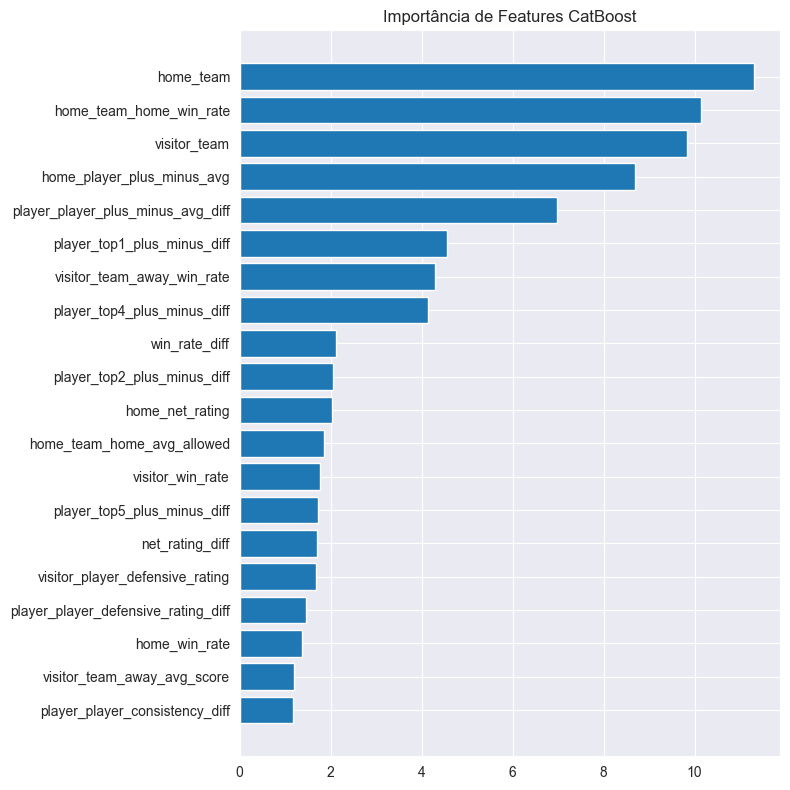


📊 Plot SHAP summary das principais variáveis


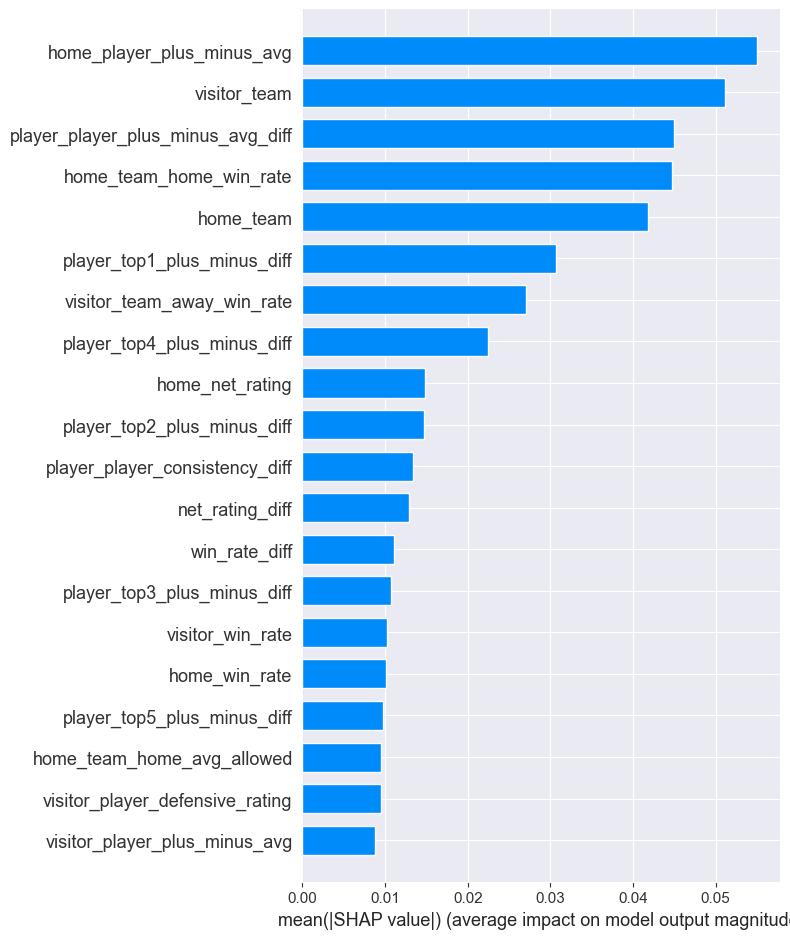

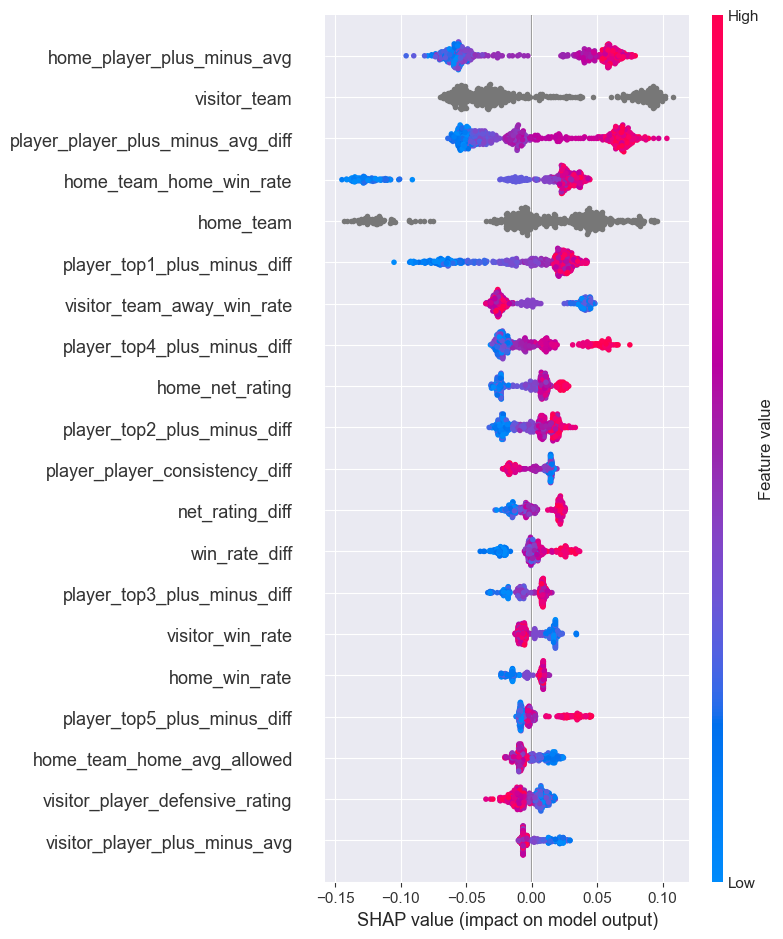


📊 Calculando acurácia por time...

🏆 TOP 10 Times por Acurácia:
time  jogos_como_home  acuracia_home  jogos_como_visitor  acuracia_visitor  total_jogos  total_acertos  acuracia_geral_time
 OKC               32       0.843750                  30          0.766667           62             50             0.806452
 UTA               28       0.714286                  25          0.800000           53             40             0.754717
 CHA               16       0.750000                  24          0.750000           40             30             0.750000
 WAS               25       0.840000                  27          0.666667           52             39             0.750000
 PHI               26       0.653846                  26          0.730769           52             36             0.692308
 GSW               33       0.727273                  32          0.656250           65             45             0.692308
 BOS               29       0.689655                  29          0

In [16]:
# printa o pacotão de métricas do teste pra ver se o modelo tá entregando
print("\n📈 RESULTADOS FINAIS:")
print("=" * 60)
print(f"Acurácia: {acc:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Log Loss: {ll:.4f}")

# baseline da classe majoritária pra ter uma régua simples de comparação
p = y_test.mean()
baseline_acc = max(p, 1 - p) if 0 < p < 1 else 1.0
print(f"Baseline (classe majoritária): {baseline_acc:.4f}")
print(f"Melhoria sobre baseline: +{(acc - baseline_acc):.4f}")

# checa viés do modelo olhando quantas previsões vão pro time da casa
home_preds_pct = float((y_pred_proba > 0.5).mean())
print(f"\nViés do modelo: {home_preds_pct:.1%} previsões para time da casa")

# inicializa estruturas de calibração; por padrão fica tudo bruto
calibrated_model = None
y_pred_proba_cal = y_pred_proba

# se o viés sair da faixa razoável, liga calibração isotônica usando um recorte do fim do treino
if home_preds_pct > 0.65 or home_preds_pct < 0.45:
    print("⚠️ Aplicando calibração devido a viés detectado...")
    calib_cut = train_df['date'].quantile(0.85)
    X_calib = train_df[train_df['date'] >= calib_cut][available_features]
    y_calib = train_df[train_df['date'] >= calib_cut][target]
    # fallback se o recorte ficar pequeno demais
    if len(X_calib) < 100:
        X_calib = X_train
        y_calib = y_train

    # calibra em cima do modelo já treinado (prefit) e reavalia
    calibrated_model = CalibratedClassifierCV(final_model, method='isotonic', cv='prefit')
    calibrated_model.fit(X_calib, y_calib)
    y_pred_proba_cal = calibrated_model.predict_proba(X_test)[:, 1]
    y_pred_cal = (y_pred_proba_cal >= 0.5).astype(int)
    acc_cal = accuracy_score(y_test, y_pred_cal)
    auc_roc_cal = roc_auc_score(y_test, y_pred_proba_cal)
    ll_cal = log_loss(y_test, y_pred_proba_cal)

    print("\n📈 Resultados após calibração isotônica:")
    print("=" * 60)
    print(f"Acurácia calibrada: {acc_cal:.4f}")
    print(f"AUC-ROC calibrada: {auc_roc_cal:.4f}")
    print(f"Log Loss calibrado: {ll_cal:.4f}")

    # tenta plotar curva de confiabilidade pra ver se as probs estão bem calibradas
    try:
        prob_true_raw, prob_pred_raw = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='quantile')
        prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_pred_proba_cal, n_bins=10, strategy='quantile')
        plt.figure(figsize=(6, 6))
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfeita')
        plt.plot(prob_pred_raw, prob_true_raw, marker='o', label='Sem calibração')
        plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrada')
        plt.xlabel('Probabilidade prevista')
        plt.ylabel('Fração positiva')
        plt.title('Curva de Confiabilidade')
        plt.legend()
        plt.tight_layout()
        plt.show()
    except:
        # se não tiver libs de plot no ambiente, segue o jogo sem travar
        pass
else:
    # se não detectou viés, mantém probs brutas e segue
    print("Sem calibração adicional.")

# relatório com threshold 0.5 nas probs brutas
avaliar_predictions(y_test, y_pred_proba, 0.5, "Bruta")
# se calibrado, mostra também relatório calibrado
if calibrated_model is not None:
    avaliar_predictions(y_test, y_pred_proba_cal, 0.5, "Calibrada")

# tenta extrair importâncias do catboost e plotar um barh simples
fi_df = None
try:
    importances = final_model.get_feature_importance()
    feat_names = list(X_train.columns)
    fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
    print("\n🏅 Top 20 importâncias de features:")
    print(fi_df.head(20).to_string(index=False))
    plt.figure(figsize=(8, 8))
    top_n = 20
    plt.barh(fi_df.head(top_n)['feature'][::-1], fi_df.head(top_n)['importance'][::-1])
    plt.title('Importância de Features CatBoost')
    plt.tight_layout()
    plt.show()
except:
    # sem stress se não der pra pegar FI ou plotar agora
    pass

# shap opcional pra explicabilidade; roda numa amostra pra não moer o tempo
try:
    n_sample = min(500, len(X_test))
    if n_sample >= 50:
        X_shap = X_test.sample(n=n_sample, random_state=42)
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_shap)
        print("\n📊 Plot SHAP summary das principais variáveis")
        shap.summary_plot(shap_values, X_shap, show=True, plot_type='bar', max_display=20)
        shap.summary_plot(shap_values, X_shap, show=True, max_display=20)
except:
    # se shap não estiver disponível, vida que segue
    pass

# visão por time pra caçar vieses específicos de franquia
print("\n📊 Calculando acurácia por time...")
df_acuracia_time = calcular_acuracia_por_time(test_df, y_test, y_pred)
df_acuracia_time = df_acuracia_time.sort_values('acuracia_geral_time', ascending=False)

print("\n🏆 TOP 10 Times por Acurácia:")
print(df_acuracia_time.head(10).to_string(index=False))
print("\n📉 BOTTOM 10 Times por Acurácia:")
print(df_acuracia_time.tail(10).to_string(index=False))

# final do log no console pra separar visualmente execuções
print("\n" + "=" * 80)
print("EXECUÇÃO CONCLUÍDA")
print("=" * 80)

# começa a parte de persistência: salva tudo em um excel com várias abas pra documentação do experimento
print("\n💾 SALVANDO RESULTADOS EM EXCEL...")

# helper pra remover timezone das colunas datetime e evitar warning no excel
def remove_timezone(df):
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            try:
                df[col] = df[col].dt.tz_localize(None)
            except Exception:
                pass
    return df

# escreve cada aba com um tema específico
with pd.ExcelWriter('nba_model_results.xlsx', engine='openpyxl') as writer:
    # 1. dataset completo de features geradas
    print("1. Salvando dataset de features...")
    df_features_final_fixed = remove_timezone(df_features_final.copy())
    df_features_final_fixed.to_excel(writer, sheet_name='Dataset_Features', index=False)

    # 2. previsões do conjunto de teste com flags de acerto
    print("2. Salvando previsões do teste...")
    test_predictions = test_df.copy()
    test_predictions = remove_timezone(test_predictions)
    test_predictions['predicted_prob'] = y_pred_proba
    test_predictions['predicted_class'] = y_pred
    test_predictions['actual'] = y_test
    test_predictions['correct'] = (test_predictions['predicted_class'] == test_predictions['actual']).astype(int)

    # se teve calibração, salva também as colunas calibradas
    if calibrated_model is not None:
        test_predictions['predicted_prob_calibrated'] = y_pred_proba_cal
        test_predictions['predicted_class_calibrated'] = (y_pred_proba_cal >= 0.5).astype(int)
        test_predictions['correct_calibrated'] = (
            test_predictions['predicted_class_calibrated'] == test_predictions['actual']
        ).astype(int)

    test_predictions.to_excel(writer, sheet_name='Test_Predictions', index=False)

    # 3. acurácia por time
    print("3. Salvando acurácia por time...")
    df_acuracia_time.to_excel(writer, sheet_name='Accuracy_Per_Team', index=False)

    # 4. métricas gerais em formato chave-valor
    print("4. Salvando métricas gerais...")
    metrics_data = {
        'Métrica': [
            'Acurácia', 'AUC-ROC', 'Log Loss',
            'Baseline Accuracy', 'Melhoria sobre Baseline',
            'Precision', 'Recall', 'F1-Score',
            'Total Jogos Treino', 'Total Jogos Teste',
            'Taxa Vitória Casa (Real)', 'Taxa Vitória Casa (Prevista)',
            'Confiança Média Previsões'
        ],
        'Valor': [
            f"{acc:.4f}", f"{auc_roc:.4f}", f"{ll:.4f}",
            f"{baseline_acc:.4f}", f"{(acc - baseline_acc):.4f}",
            f"{precision_score(y_test, y_pred):.4f}",
            f"{recall_score(y_test, y_pred):.4f}",
            f"{f1_score(y_test, y_pred):.4f}",
            f"{len(train_df)}", f"{len(test_df)}",
            f"{y_test.mean():.4f}", f"{home_preds_pct:.4f}",
            f"{avg_conf:.4f}"
        ]
    }

    # adiciona bloco calibrado se rolou calibração
    if calibrated_model is not None:
        metrics_data['Métrica'].extend([
            'Acurácia Calibrada', 'AUC-ROC Calibrada', 'Log Loss Calibrado',
            'Precision Calibrada', 'Recall Calibrado', 'F1-Score Calibrado'
        ])
        metrics_data['Valor'].extend([
            f"{acc_cal:.4f}", f"{auc_roc_cal:.4f}", f"{ll_cal:.4f}",
            f"{precision_score(y_test, y_pred_cal):.4f}",
            f"{recall_score(y_test, y_pred_cal):.4f}",
            f"{f1_score(y_test, y_pred_cal):.4f}"
        ])

    df_metrics = pd.DataFrame(metrics_data)
    df_metrics.to_excel(writer, sheet_name='General_Metrics', index=False)

    # 5. importâncias de features
    print("5. Salvando feature importances...")
    if fi_df is not None:
        fi_df.to_excel(writer, sheet_name='Feature_Importances', index=False)
    else:
        pd.DataFrame({'Message': ['Feature importance não disponível']}).to_excel(
            writer, sheet_name='Feature_Importances', index=False
        )

    # 6. comparação de modelos por configuração testada
    print("6. Salvando comparação de modelos...")
    model_comparison = []
    for config_str, results in config_results.items():
        model_comparison.append({
            'Configuração': config_str,
            'AUC_Mean': results['auc'],
            'AUC_Std': results['std'],
            'Melhor': '✓' if config_str == str(best_config) else ''
        })

    df_model_comp = pd.DataFrame(model_comparison).sort_values('AUC_Mean', ascending=False)
    df_model_comp.to_excel(writer, sheet_name='Model_Comparison', index=False)

    # 7. ablação pra mostrar ganho incremental das famílias de features
    print("7. Salvando análise de ablação...")
    ablation_data = []

    # baseline básico com poucas features pra servir de referência
    baseline_features = [
        'home_win_rate', 'visitor_win_rate', 'home_net_rating', 'visitor_net_rating',
        'win_rate_diff', 'net_rating_diff', 'home_rest_days', 'visitor_rest_days'
    ]
    available_baseline = [f for f in baseline_features if f in available_features]

    if len(available_baseline) >= 3:
        try:
            baseline_model = CatBoostClassifier(
                iterations=100, random_seed=42, verbose=False, early_stopping_rounds=20
            )
            baseline_model.fit(
                X_train[available_baseline], y_train,
                eval_set=(X_test[available_baseline], y_test),
                verbose=0
            )
            y_pred_baseline = baseline_model.predict(X_test[available_baseline])
            y_proba_baseline = baseline_model.predict_proba(X_test[available_baseline])[:, 1]

            ablation_data.append({
                'Modelo': 'Baseline (Features Básicas)',
                'Acurácia': accuracy_score(y_test, y_pred_baseline),
                'AUC': roc_auc_score(y_test, y_proba_baseline),
                'Log_Loss': log_loss(y_test, y_proba_baseline),
                'N_Features': len(available_baseline)
            })
        except Exception as e:
            # se a ablação der ruim aqui, só loga e segue
            print(f"Erro no modelo baseline: {e}")

    # modelo sem player features pra medir o peso do bloco de jogadores
    features_without_players = [f for f in available_features if not any(x in f for x in ['player_', 'top_'])]
    if len(features_without_players) > 10:
        try:
            no_player_model = CatBoostClassifier(
                iterations=100, random_seed=42, verbose=False, early_stopping_rounds=20
            )
            no_player_model.fit(
                X_train[features_without_players], y_train,
                eval_set=(X_test[features_without_players], y_test),
                verbose=0
            )
            y_pred_no_player = no_player_model.predict(X_test[features_without_players])
            y_proba_no_player = no_player_model.predict_proba(X_test[features_without_players])[:, 1]

            ablation_data.append({
                'Modelo': 'Sem Player Features',
                'Acurácia': accuracy_score(y_test, y_pred_no_player),
                'AUC': roc_auc_score(y_test, y_proba_no_player),
                'Log_Loss': log_loss(y_test, y_proba_no_player),
                'N_Features': len(features_without_players)
            })
        except Exception as e:
            print(f"Erro no modelo sem player features: {e}")

    # sempre registra o modelo final completo como referência principal
    ablation_data.append({
        'Modelo': 'Modelo Final (Completo)',
        'Acurácia': acc,
        'AUC': auc_roc,
        'Log_Loss': ll,
        'N_Features': len(available_features)
    })

    # se teve calibração, adiciona a variante calibrada
    if calibrated_model is not None:
        ablation_data.append({
            'Modelo': 'Modelo Final Calibrado',
            'Acurácia': acc_cal,
            'AUC': auc_roc_cal,
            'Log_Loss': ll_cal,
            'N_Features': len(available_features)
        })

    df_ablation = pd.DataFrame(ablation_data)
    df_ablation.to_excel(writer, sheet_name='Ablation_Analysis', index=False)

    # 8. análise de thresholds pra facilitar escolha operacional do ponto de corte
    print("8. Salvando análise de threshold...")
    thresholds = np.arange(0.3, 0.71, 0.05)
    threshold_data = []

    probabilities_to_use = y_pred_proba_cal if calibrated_model is not None else y_pred_proba

    for threshold in thresholds:
        y_pred_thresh = (probabilities_to_use >= threshold).astype(int)
        threshold_data.append({
            'Threshold': threshold,
            'Acurácia': accuracy_score(y_test, y_pred_thresh),
            'Precision': precision_score(y_test, y_pred_thresh, zero_division=0),
            'Recall': recall_score(y_test, y_pred_thresh, zero_division=0),
            'F1-Score': f1_score(y_test, y_pred_thresh, zero_division=0),
            'Taxa_Positivos': y_pred_thresh.mean(),
            'VP': confusion_matrix(y_test, y_pred_thresh)[1, 1],
            'FP': confusion_matrix(y_test, y_pred_thresh)[0, 1],
            'VN': confusion_matrix(y_test, y_pred_thresh)[0, 0],
            'FN': confusion_matrix(y_test, y_pred_thresh)[1, 0]
        })

    df_threshold = pd.DataFrame(threshold_data)
    df_threshold.to_excel(writer, sheet_name='Threshold_Analysis', index=False)

    # 9. curva precision-recall e a área sob a curva pra cenários desbalanceados
    print("9. Salvando curva precision-recall...")
    precision, recall, _ = precision_recall_curve(y_test, probabilities_to_use)
    pr_auc = auc(recall, precision)
    pr_data = {'Recall': recall, 'Precision': precision}
    df_pr_curve = pd.DataFrame(pr_data)
    df_pr_curve['PR_AUC'] = pr_auc
    df_pr_curve.to_excel(writer, sheet_name='PR_Curve', index=False)

    # 10. resumo executivo com o que interessa pra colar no relatório do tcc
    print("10. Salvando resumo executivo...")
    executive_summary = {
        'ITEM': [
            'Data Execução',
            'Melhor Configuração',
            'AUC Melhor Modelo',
            'Acurácia Final',
            'Melhoria sobre Baseline',
            'Total Jogos Processados',
            'Período Treino',
            'Período Teste',
            'Top 3 Features',
            'Confiança Média',
            'Status Calibração'
        ],
        'VALOR': [
            datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            str(best_config),
            f"{best_auc:.4f}",
            f"{acc:.4f}",
            f"{(acc - baseline_acc):.4f}",
            f"{len(df_features_final)}",
            f"{train_df['date'].min().date()} a {train_df['date'].max().date()}",
            f"{test_df['date'].min().date()} a {test_df['date'].max().date()}",
            f"{fi_df['feature'].iloc[0] if fi_df is not None else 'N/A'} > {fi_df['feature'].iloc[1] if fi_df is not None else 'N/A'} > {fi_df['feature'].iloc[2] if fi_df is not None else 'N/A'}",
            f"{avg_conf:.4f}",
            'Calibrado' if calibrated_model is not None else 'Não Calibrado'
        ]
    }
    df_executive = pd.DataFrame(executive_summary)
    df_executive.to_excel(writer, sheet_name='Executive_Summary', index=False)

# pronto, relatório salvo com tudo organizado por aba
print("✅ ARQUIVO SALVO COM SUCESSO: nba_model_results.xlsx")


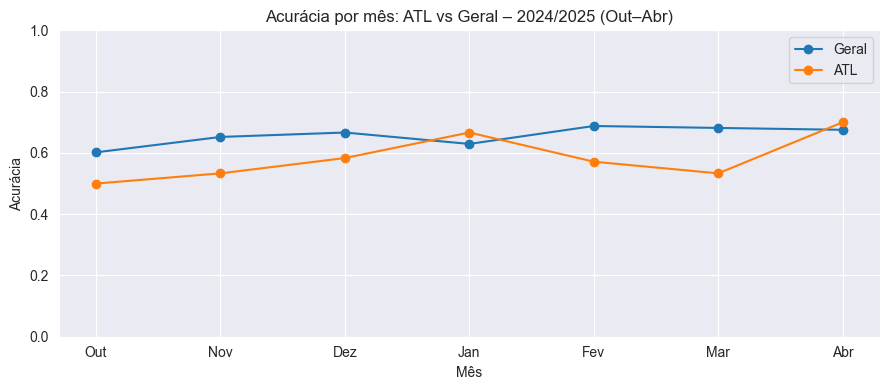

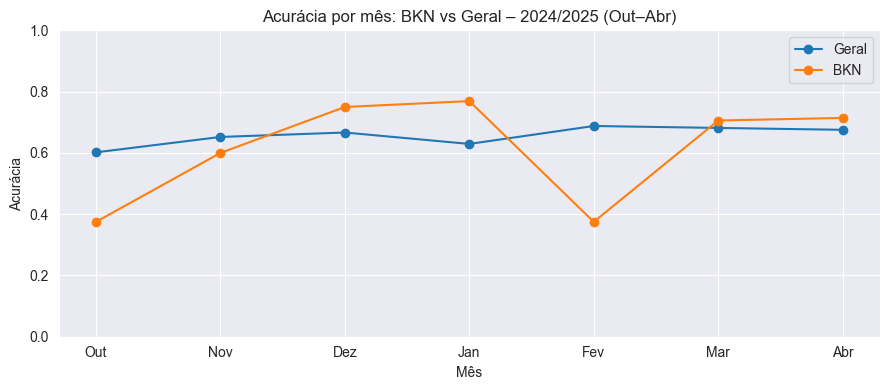

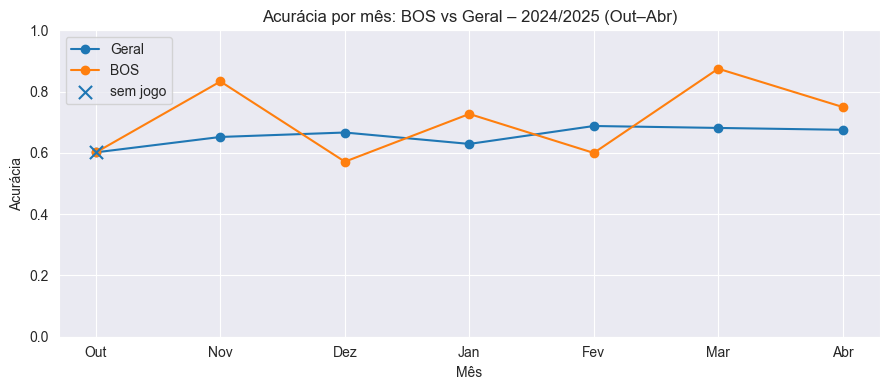

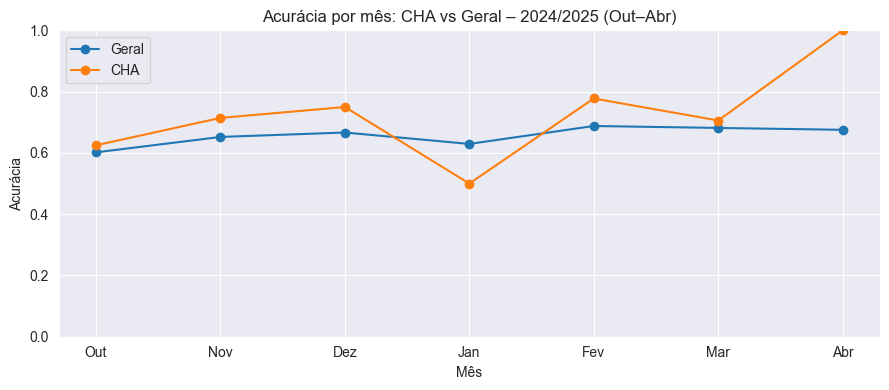

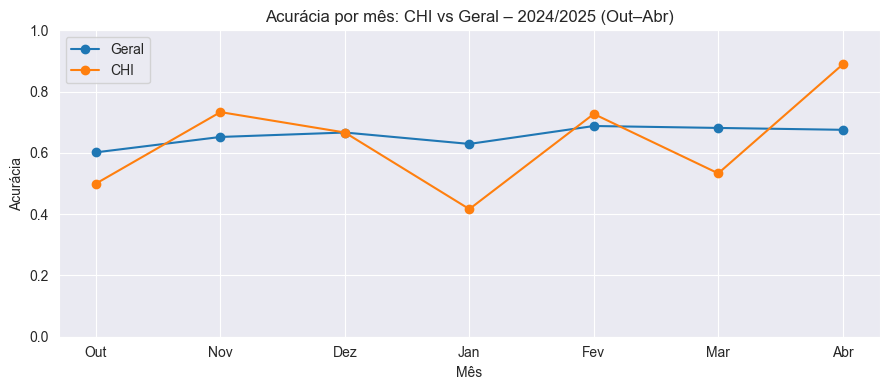

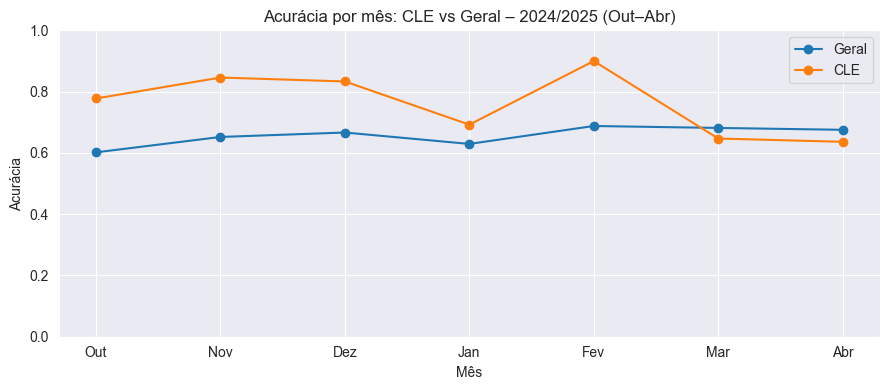

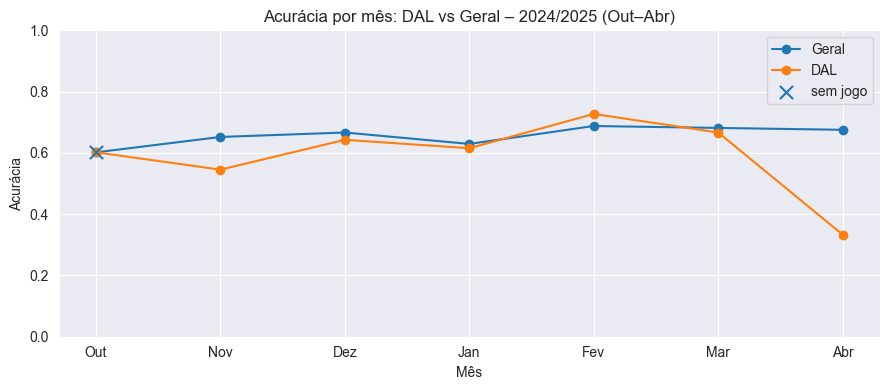

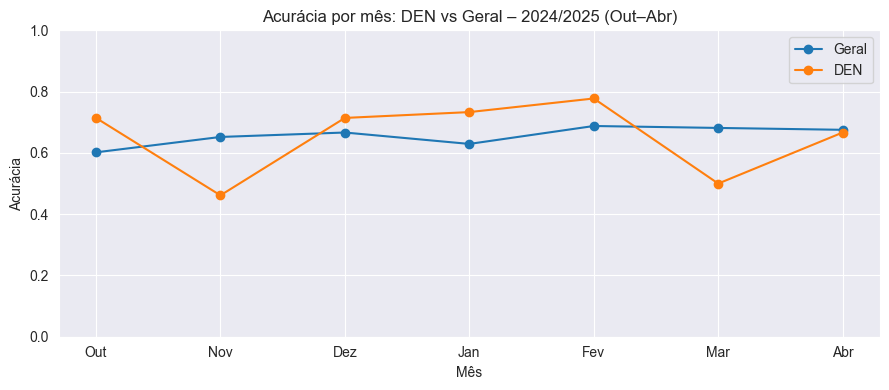

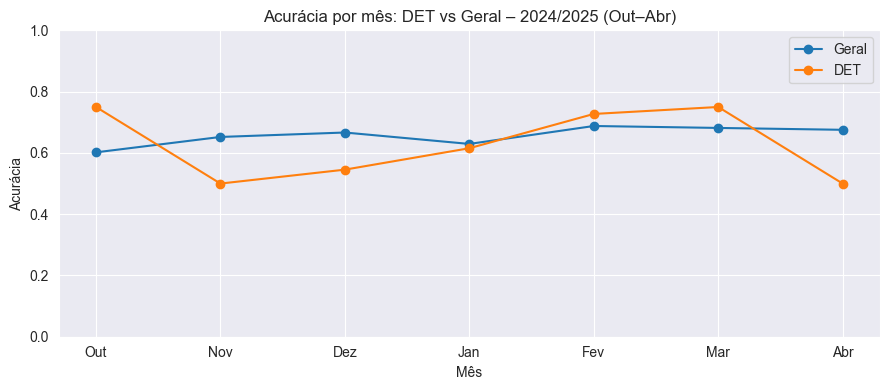

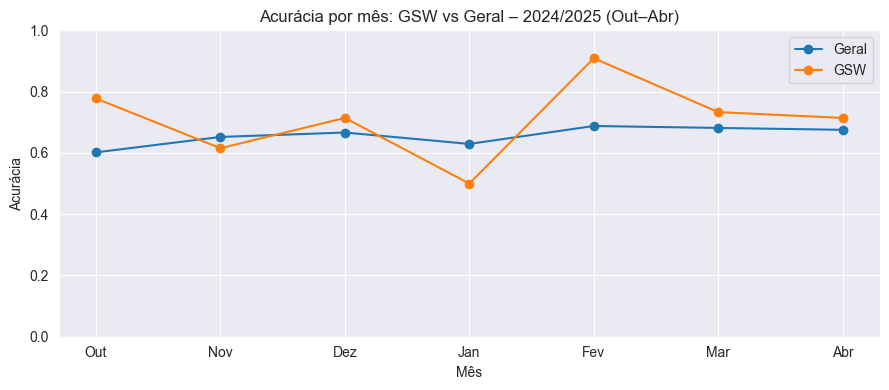

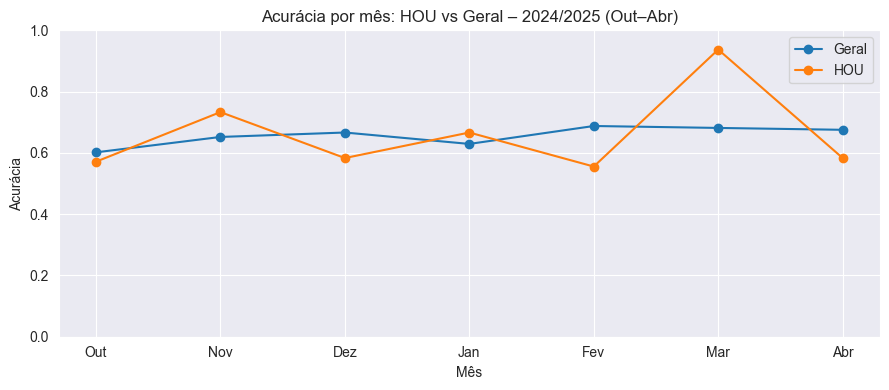

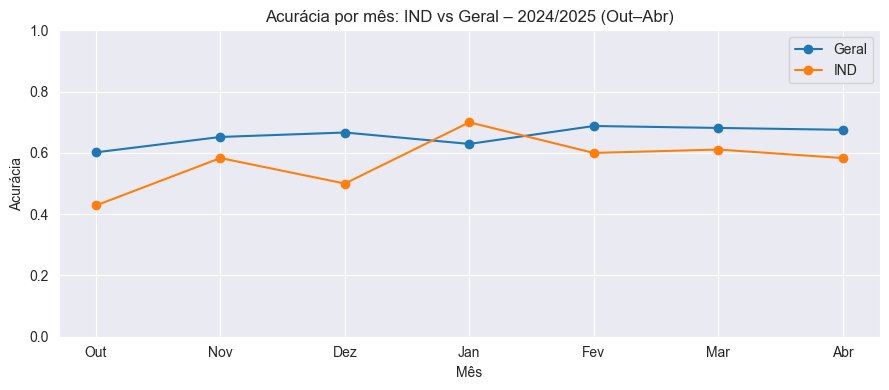

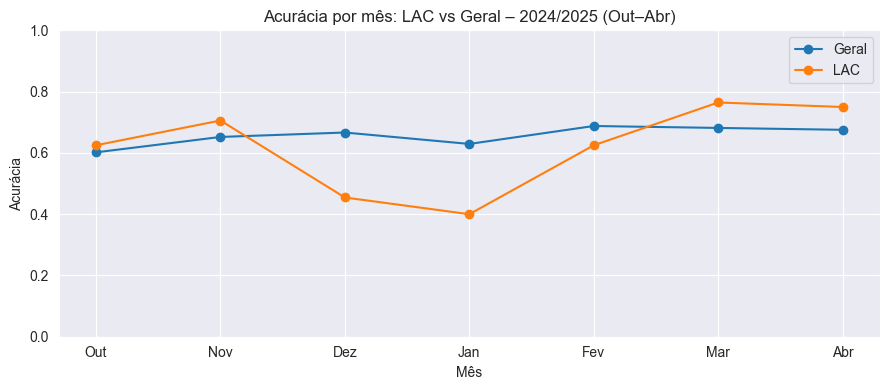

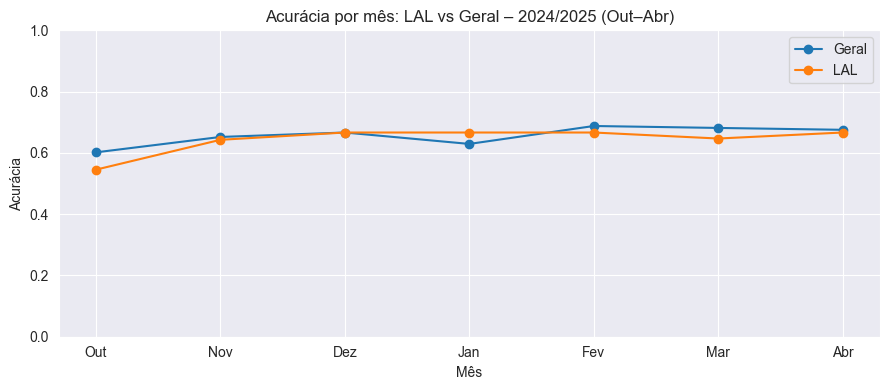

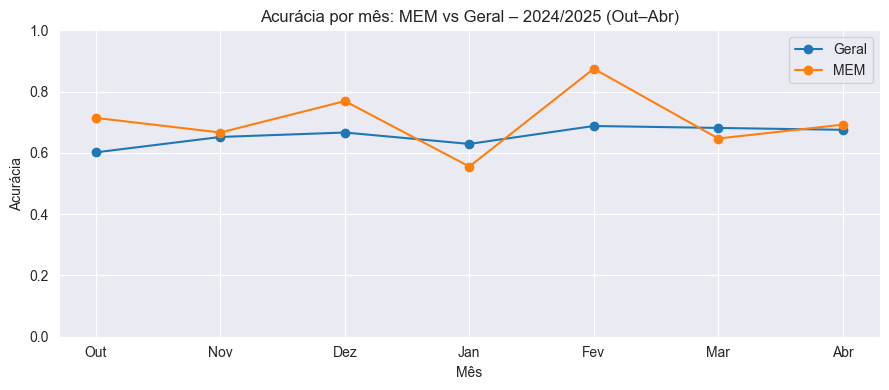

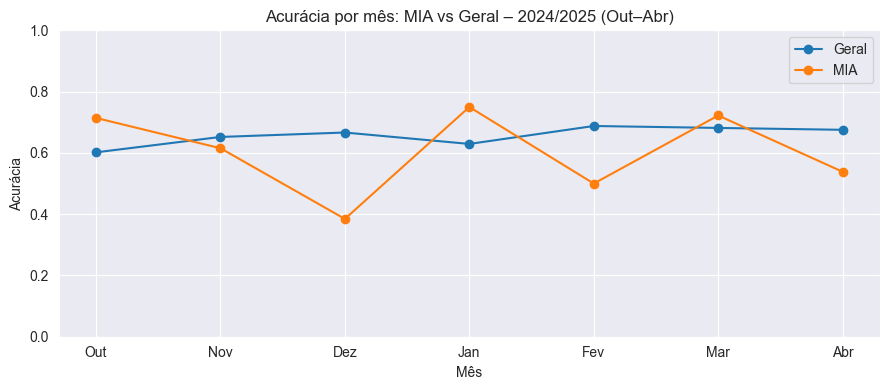

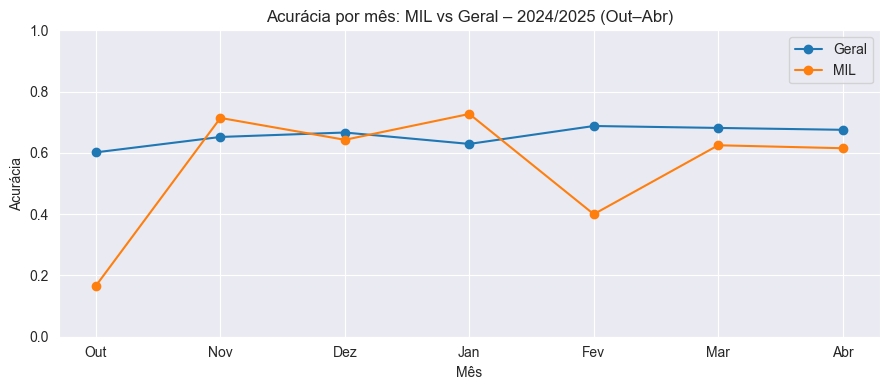

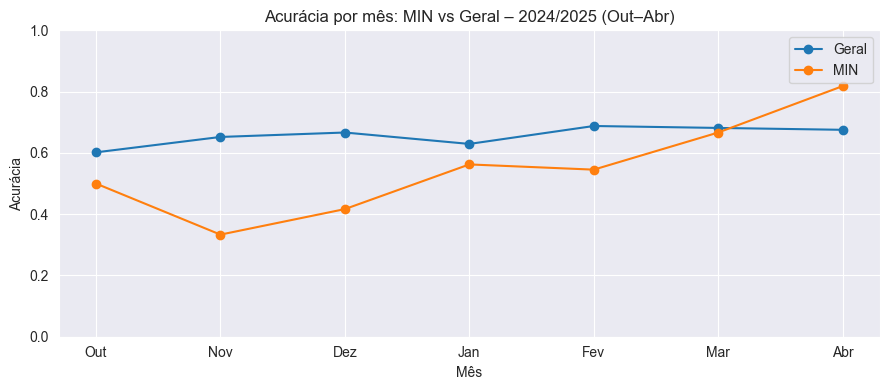

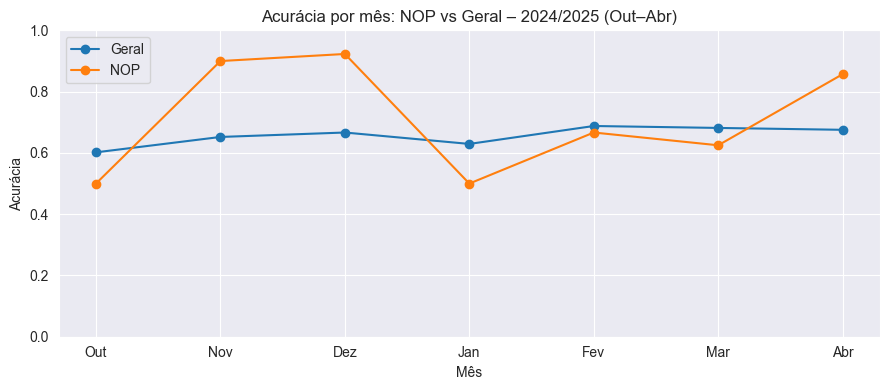

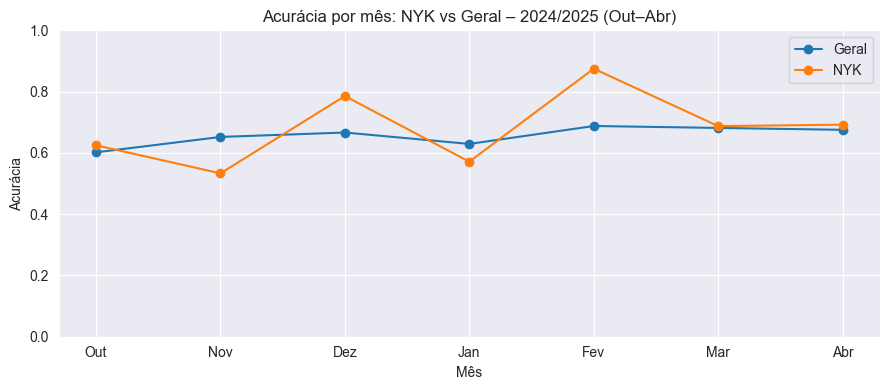

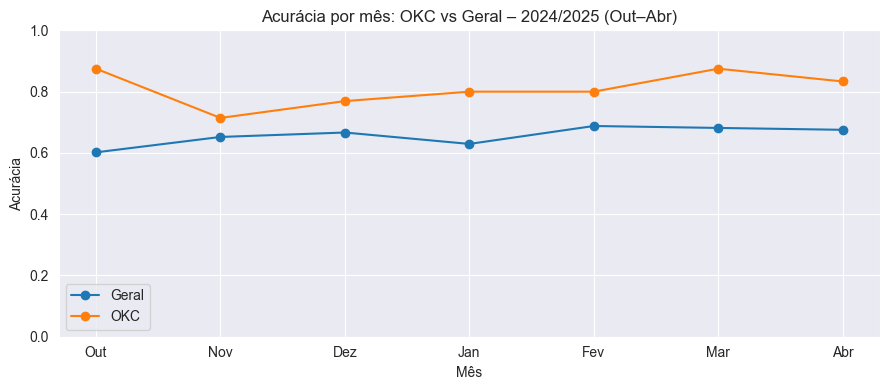

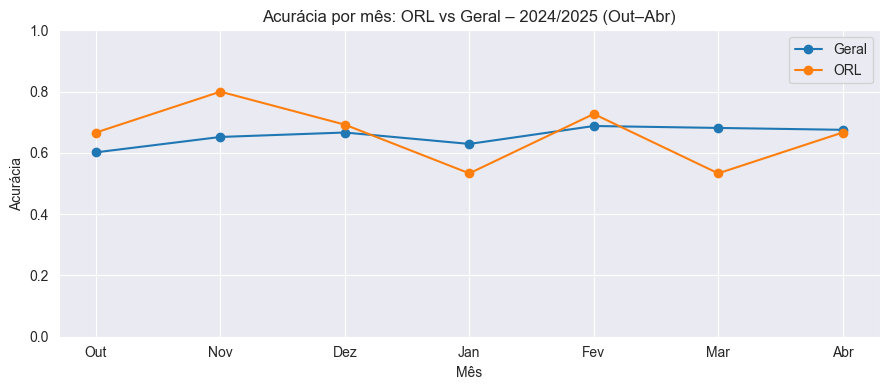

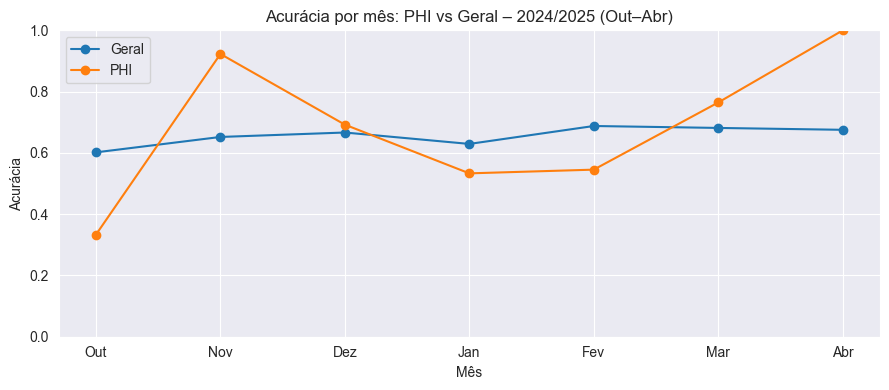

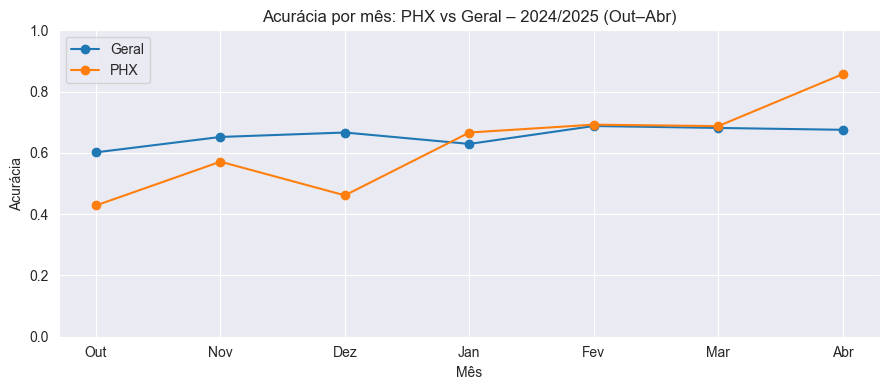

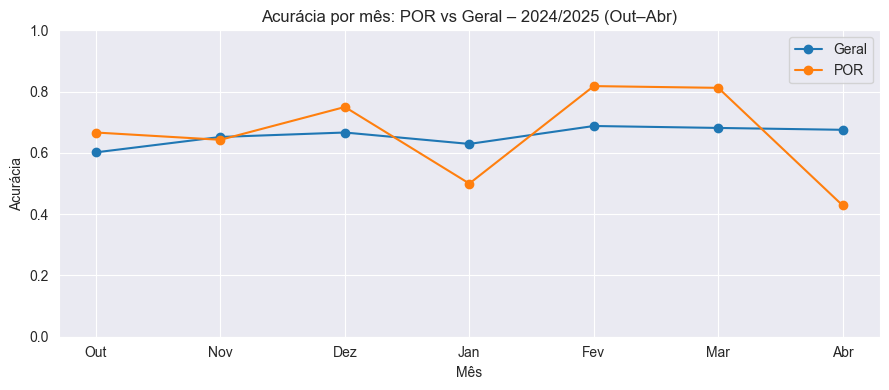

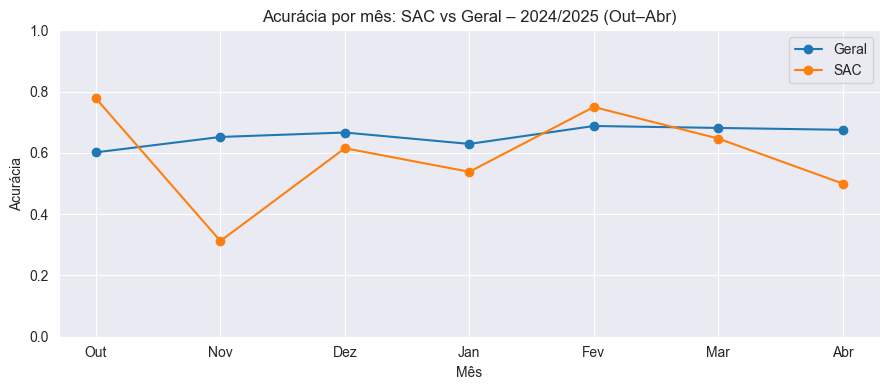

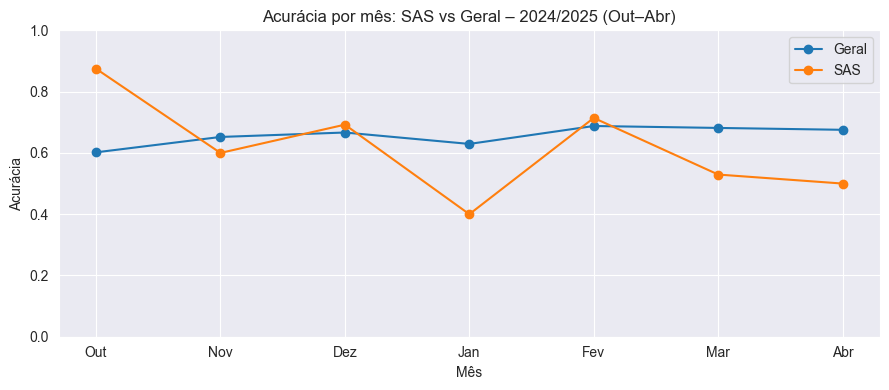

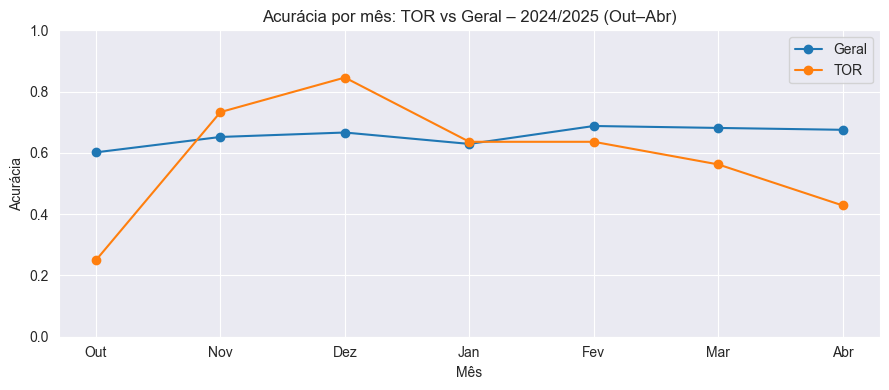

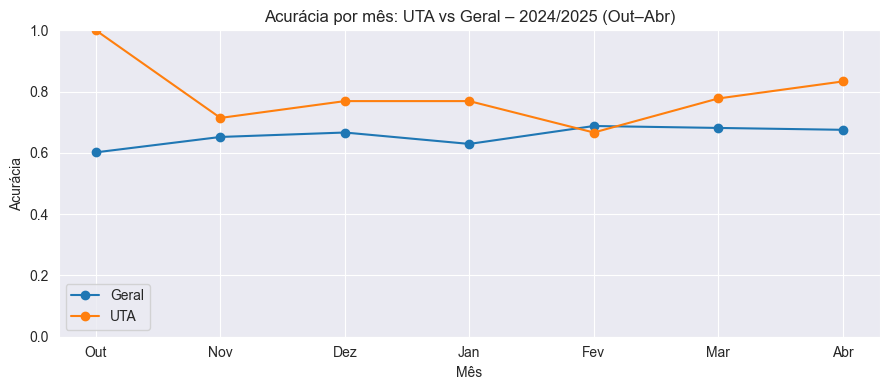

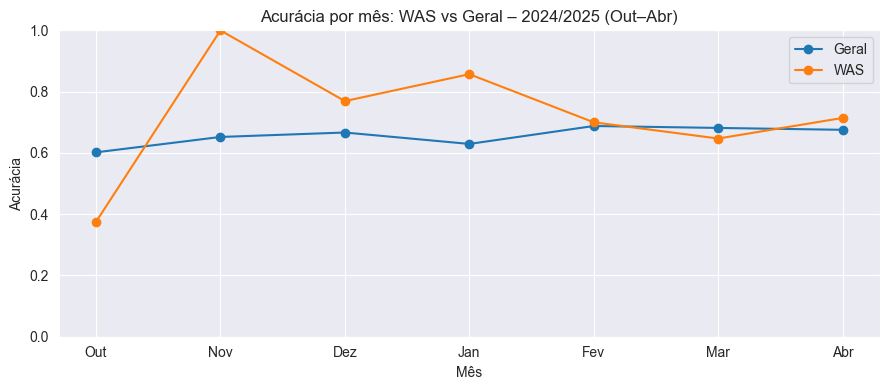

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _get_probs(m, X):
    try:
        return m.predict_proba(X)[:,1]
    except:
        from catboost import Pool
        return m.predict_proba(Pool(X))[:,1]

model = next((globals()[m] for m in ['calibrated_model','final_model','best_model','model','clf','cat_model']
              if m in globals() and globals()[m] is not None), None)

parts = []
if 'test_df' in globals() and 'y_test' in globals():
    if 'y_pred_proba_cal' in globals():
        p = y_pred_proba_cal
    elif 'y_pred_proba' in globals():
        p = y_pred_proba
    elif model is not None and any(x in globals() for x in ['X_test','Xt']):
        X = globals().get('X_test', globals().get('Xt'))
        p = _get_probs(model, X)
    else:
        p = None
    if p is not None:
        parts.append(pd.DataFrame({
            'date': pd.to_datetime(test_df['date']),
            'home_team': test_df['home_team'].values,
            'visitor_team': test_df['visitor_team'].values,
            'actual': pd.Series(y_test, index=test_df.index).astype(int).values,
            'pred': (np.asarray(p)>=0.5).astype(int)
        }))

if 'train_df' in globals() and 'y_train' in globals():
    p_train = None
    for name in ['oof_pred_proba','y_pred_proba_train','train_pred_proba','oof_proba']:
        if name in globals():
            p_train = globals()[name]; break
    if p_train is None and model is not None and 'X_train' in globals():
        p_train = _get_probs(model, X_train)
    if p_train is not None:
        parts.append(pd.DataFrame({
            'date': pd.to_datetime(train_df['date']),
            'home_team': train_df['home_team'].values,
            'visitor_team': train_df['visitor_team'].values,
            'actual': pd.Series(y_train, index=train_df.index).astype(int).values,
            'pred': (np.asarray(p_train)>=0.5).astype(int)
        }))

if 'valid_df' in globals() and 'y_valid' in globals():
    p_val = globals().get('y_pred_proba_valid', None)
    if p_val is None and model is not None and 'X_valid' in globals():
        p_val = _get_probs(model, X_valid)
    if p_val is not None:
        parts.append(pd.DataFrame({
            'date': pd.to_datetime(valid_df['date']),
            'home_team': valid_df['home_team'].values,
            'visitor_team': valid_df['visitor_team'].values,
            'actual': pd.Series(y_valid, index=valid_df.index).astype(int).values,
            'pred': (np.asarray(p_val)>=0.5).astype(int)
        }))

dfm = pd.concat(parts, ignore_index=True)

dfm['date'] = pd.to_datetime(dfm['date'], utc=True)
start = pd.Timestamp('2024-10-01', tz='UTC')
end   = pd.Timestamp('2025-05-01', tz='UTC')
dfm = dfm[(dfm['date'] >= start) & (dfm['date'] < end)]

dfm['month'] = dfm['date'].dt.month
map_mes = {10:'Out',11:'Nov',12:'Dez',1:'Jan',2:'Fev',3:'Mar',4:'Abr'}
ordem = ['Out','Nov','Dez','Jan','Fev','Mar','Abr']
dfm['mes'] = pd.Categorical(dfm['month'].map(map_mes), categories=ordem, ordered=True)
dfm['correct'] = (dfm['actual']==dfm['pred']).astype(int)

acc_por_mes = dfm.groupby('mes', sort=False)['correct'].mean().reindex(ordem)
n_geral = dfm.groupby('mes', sort=False)['correct'].size().reindex(ordem).fillna(0).astype(int)

df_pairs = pd.DataFrame({
    'date': pd.concat([dfm['date'], dfm['date']], ignore_index=True),
    'team': pd.concat([dfm['home_team'], dfm['visitor_team']], ignore_index=True),
    'mes': pd.concat([dfm['mes'].astype(str), dfm['mes'].astype(str)], ignore_index=True),
    'correct': np.tile(dfm['correct'].values, 2)
})

acc_team_month = (df_pairs.groupby(['team','mes'], sort=False)['correct']
                  .agg(['mean','size']).reset_index().rename(columns={'mean':'acc','size':'n'}))

def plot_acc_team(team):
    t = acc_team_month[acc_team_month['team']==team].set_index('mes').reindex(ordem)
    y = t['acc'].astype(float)
    n = t['n'].fillna(0).astype(int)
    y_disp = y.copy()
    mask0 = n==0
    y_disp[mask0] = acc_por_mes[mask0]
    plt.figure(figsize=(9,4))
    plt.plot(acc_por_mes.index, acc_por_mes.values, marker='o', label='Geral')
    plt.plot(ordem, y_disp.values, marker='o', label=team)
    if mask0.any():
        xs = np.array(ordem, dtype=object)[mask0.values]
        ys = acc_por_mes[mask0].values
        plt.scatter(xs, ys, marker='x', s=90, zorder=5, label='sem jogo')
    plt.ylim(0,1)
    plt.xlabel('Mês'); plt.ylabel('Acurácia')
    plt.title('Acurácia por mês: {} vs Geral – 2024/2025 (Out–Abr)'.format(team))
    plt.legend(); plt.tight_layout(); plt.show()

for t in sorted(acc_team_month['team'].unique()):
    plot_acc_team(t)


In [30]:
team = 'PHI'

probabilities_to_use = y_pred_proba_cal if ('calibrated_model' in globals() and calibrated_model is not None) else y_pred_proba
pred_all = (probabilities_to_use >= 0.5).astype(int)

te = test_df.copy()
te['date'] = pd.to_datetime(te['date'])
te['actual'] = pd.Series(y_test).values
te['pred'] = pd.Series(pred_all).values
te['proba'] = probabilities_to_use
te['correct'] = (te['pred'] == te['actual']).astype(int)
te['month'] = te['date'].dt.month

apr = te[(te['month']==4) & ((te['home_team']==team) | (te['visitor_team']==team))].copy()
apr['pred_winner'] = np.where(apr['pred']==1, apr['home_team'], apr['visitor_team'])
apr['actual_winner'] = np.where(apr['actual']==1, apr['home_team'], apr['visitor_team'])

print(f"Jogos {team} em abril: {len(apr)}  |  Acurácia: {apr['correct'].mean():.3f}")
display_cols = ['date','home_team','visitor_team','actual_winner','pred_winner','proba','correct']
print(apr.sort_values('date')[display_cols].to_string(index=False))


Jogos PHI em abril: 7  |  Acurácia: 1.000
                     date home_team visitor_team actual_winner pred_winner    proba  correct
2025-04-01 23:30:00+00:00       NYK          PHI           NYK         NYK 0.611671        1
2025-04-03 23:00:00+00:00       PHI          MIL           MIL         MIL 0.383705        1
2025-04-05 23:00:00+00:00       PHI          MIN           MIN         MIN 0.365247        1
2025-04-07 23:30:00+00:00       MIA          PHI           MIA         MIA 0.565909        1
2025-04-09 23:00:00+00:00       WAS          PHI           PHI         PHI 0.418252        1
2025-04-11 23:00:00+00:00       PHI          ATL           ATL         ATL 0.430496        1
2025-04-13 17:00:00+00:00       PHI          CHI           CHI         CHI 0.371740        1


In [19]:
import pandas as pd
import numpy as np
import shap
from pandas.api.types import is_numeric_dtype
import os


#max_games = 100
max_games = len(X_test)
id_cols = [c for c in ["game_id","date","home_team","visitor_team"] if c in test_df.columns]

print("Calculando SHAP values...")

explainer = shap.TreeExplainer(final_model)

shap_values = explainer.shap_values(X_test)


if isinstance(shap_values, list):
    shap_values = shap_values[1]

per_game_rows = []

num_games = min(len(X_test), max_games)

for i in range(num_games):
    if i % 100 == 0:
        print(f"Processando jogo {i}...")

    game_shap_values = shap_values[i]

    feature_impacts = {}
    for j, feature in enumerate(X_test.columns):
        feature_impacts[feature] = game_shap_values[j]

    sorted_impacts = sorted(feature_impacts.items(), key=lambda x: abs(x[1]), reverse=True)

    top_features = sorted_impacts[:5]

    row_df = X_test.iloc[i:i+1]
    p0 = float(final_model.predict_proba(row_df)[:,1][0])

    rec = {k: test_df.iloc[i][k] for k in id_cols}
    rec["p0"] = p0

    for j, (feature, impact) in enumerate(top_features, 1):
        rec[f"top{j}_feat"] = feature
        rec[f"top{j}_shap"] = impact
        rec[f"top{j}_feat_value"] = X_test.iloc[i][feature]

    per_game_rows.append(rec)

per_game_groups_rows = []

groups = {
    "time": [c for c in X_test.columns if c in {
        "home_win_rate","visitor_win_rate","home_avg_points","visitor_avg_points",
        "home_avg_points_allowed","visitor_avg_points_allowed",
        "home_net_rating","visitor_net_rating",
        "home_off_vs_visitor_def","visitor_off_vs_home_def",
        "net_rating_diff","win_rate_diff","points_diff"
    }],
    "calendario": [c for c in X_test.columns if c in {
        "home_rest_days","visitor_rest_days","home_back_to_back","visitor_back_to_back",
        "home_games_last_week","visitor_games_last_week","days_into_season","rest_advantage",
        "month","day_of_week","is_weekend"
    }],
    "jogadores": [c for c in X_test.columns if c.startswith("home_player_") or c.startswith("visitor_player_") or c.startswith("player_")],
    "diferenciais": [c for c in X_test.columns if c.endswith("_diff")]
}

for i in range(num_games):
    if i % 100 == 0:
        print(f"Processando grupos do jogo {i}...")

    game_shap_values = shap_values[i]
    row_df = X_test.iloc[i:i+1]
    p0 = float(final_model.predict_proba(row_df)[:,1][0])

    for group_name, group_features in groups.items():
        if not group_features:
            continue

        group_impact = 0.0
        for feature in group_features:
            if feature in X_test.columns:
                feature_idx = list(X_test.columns).index(feature)
                group_impact += abs(game_shap_values[feature_idx])

        per_game_groups_rows.append({
            **{k: test_df.iloc[i][k] for k in id_cols},
            "p0": p0,
            "group": group_name,
            "shap_impact": group_impact
        })

per_game_df = pd.DataFrame(per_game_rows)
per_game_groups_df = pd.DataFrame(per_game_groups_rows)

def remove_timezone(df):
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].dt.tz_localize(None)
    return df

per_game_df = remove_timezone(per_game_df)
per_game_groups_df = remove_timezone(per_game_groups_df)

try:
    excel_file = 'nba_model_results.xlsx'

    if os.path.exists(excel_file):
        try:
            test_df_check = pd.read_excel(excel_file, sheet_name=0)
            print("✅ Arquivo Excel existente é válido.")
        except Exception as e:
            print(f"⚠️ Arquivo Excel existente está corrompido. Criando novo arquivo.")
            excel_file = 'nba_model_results_SHAP.xlsx'

    with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        per_game_df.to_excel(writer, sheet_name='Per_Game_SHAP', index=False)
        per_game_groups_df.to_excel(writer, sheet_name='Per_Game_Group_SHAP', index=False)
    print(f"✅ SHAP por jogo salvo em '{excel_file}'.")

except Exception as e:
    print(f"❌ Erro ao salvar no arquivo principal: {e}")
    backup_file = 'nba_model_results_SHAP.xlsx'
    try:
        with pd.ExcelWriter(backup_file, engine='openpyxl') as writer:
            per_game_df.to_excel(writer, sheet_name='Per_Game_SHAP', index=False)
            per_game_groups_df.to_excel(writer, sheet_name='Per_Game_Group_SHAP', index=False)
        print(f"✅ SHAP por jogo salvo em arquivo backup '{backup_file}'.")
    except Exception as backup_error:
        print(f"❌ Erro também ao salvar backup: {backup_error}")
        per_game_df.to_csv('nba_per_game_shap.csv', index=False)
        per_game_groups_df.to_csv('nba_per_game_group_shap.csv', index=False)
        print("✅ Dados salvos como CSV como último recurso.")

print("\n📊 Gerando gráficos de importância global...")

try:
    shap_sum = np.abs(shap_values).mean(0)
    importance_df = pd.DataFrame([X_test.columns, shap_sum]).T
    importance_df.columns = ['feature', 'shap_importance']
    importance_df = importance_df.sort_values('shap_importance', ascending=False)

    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist(), show=False, plot_size=(12, 8))
    import matplotlib.pyplot as plt
    plt.title("SHAP Summary Plot - NBA Model")
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ Gráfico SHAP salvo como 'shap_summary_plot.png'")

except Exception as plot_error:
    print(f"❌ Erro ao gerar gráfico SHAP: {plot_error}")

print("✅ Análise SHAP completa!")

Calculando SHAP values...
Processando jogo 0...
Processando jogo 100...
Processando jogo 200...
Processando jogo 300...
Processando jogo 400...
Processando jogo 500...
Processando jogo 600...
Processando jogo 700...
Processando grupos do jogo 0...
Processando grupos do jogo 100...
Processando grupos do jogo 200...
Processando grupos do jogo 300...
Processando grupos do jogo 400...
Processando grupos do jogo 500...
Processando grupos do jogo 600...
Processando grupos do jogo 700...
✅ Arquivo Excel existente é válido.
✅ SHAP por jogo salvo em 'nba_model_results.xlsx'.

📊 Gerando gráficos de importância global...
✅ Gráfico SHAP salvo como 'shap_summary_plot.png'
✅ Análise SHAP completa!


In [20]:
import pickle

print("\n💾 Salvando modelo com metadata...")


data_to_save = {
    'model': final_model,
    'features': list(X_train.columns),
    'categorical_features': [f for f in categorical_features if f in available_features]
}

with open('nba_model_final.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print("✅ Modelo + features salvos com sucesso!")


💾 Salvando modelo com metadata...


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/TCC/nba_model_final.pkl'

In [ ]:
with open('/content/drive/MyDrive/TCC/nba_model_final.pkl', 'wb') as f:
    pickle.dump({
        'model': final_model,
        'features': list(X_train.columns),
        'categorical_features': [f for f in categorical_features if f in available_features]
    }, f)

In [ ]:
print("\n👥 Processando dados dos jogadores (genérico)...")

home_team_code = globals().get('home_team_code', 'OKC')
visitor_team_code = globals().get('visitor_team_code', 'IND')
team_rosters = globals().get('team_rosters', {})

# detectar coluna de nome do jogador
name_col = None
for col in df_players.columns:
    if col.lower() in ['name', 'player_name', 'player']:
        name_col = col
        break
if name_col is None:
    print("❌ Coluna de nome não encontrada nos dados de jogadores")
    name_col = 'player_name'
else:
    print(f"✅ Usando coluna: '{name_col}'")

def auto_pick_players(df_players, team_code, start_date, end_date, name_col='player_name', top_n=12):
    mask = (
        (df_players.get('team_code', pd.Series(dtype=str)) == team_code) &
        (df_players['date'] >= start_date) & (df_players['date'] <= end_date) &
        (df_players['min'] >= 1) & (df_players['min'] <= 48)
    )
    df = df_players.loc[mask, [name_col, 'points', 'min']]
    if df.empty:
        return []
    agg = df.groupby(name_col).agg(gp=('points','mean'), mp=('min','mean'), n=('points','size')).reset_index()
    agg = agg.sort_values(['mp','gp','n'], ascending=False).head(top_n)
    return agg[name_col].tolist()

# montar elencos
home_player_names = team_rosters.get(home_team_code) or auto_pick_players(df_players, home_team_code, analysis_start_date, latest_data_date, name_col)
visitor_player_names = team_rosters.get(visitor_team_code) or auto_pick_players(df_players, visitor_team_code, analysis_start_date, latest_data_date, name_col)

print(f"  {home_team_code}: {len(home_player_names)} jogadores")
print(f"  {visitor_team_code}: {len(visitor_player_names)} jogadores")

# cálculos com dados realistas
print(f"\n📊 Buscando dados REALISTAS da última temporada...")
print(f"   Período de análise: {analysis_start_date.date()} até {latest_data_date.date()}")

home_stats_players = calculate_accurate_player_stats(df_players, home_team_code, home_player_names, latest_data_date, name_col)
visitor_stats_players = calculate_accurate_player_stats(df_players, visitor_team_code, visitor_player_names, latest_data_date, name_col)

print(f"\n🏀 Calculando estatísticas REALISTAS dos times...")
home_team_stats = calculate_accurate_team_stats(df_games, home_team_code, latest_data_date)
visitor_team_stats = calculate_accurate_team_stats(df_games, visitor_team_code, latest_data_date)

def infer_season_phase(game_dt):
    start_year = game_dt.year if game_dt.month >= 7 else game_dt.year - 1
    season_start = datetime(start_year, 10, 1, tzinfo=game_dt.tzinfo)
    days = (game_dt - season_start).days
    if days < 60:
        return 'early', max(days, 0)
    if days < 140:
        return 'mid', days
    return 'late', days

def h2h_home_win_rate(df_games, home_code, visitor_code, start_date, end_date):
    g = df_games[
        (df_games['date'] >= start_date) & (df_games['date'] <= end_date) &
        (
            ((df_games['home_team'] == home_code) & (df_games['visitor_team'] == visitor_code)) |
            ((df_games['home_team'] == visitor_code) & (df_games['visitor_team'] == home_code))
        )
    ]
    if g.empty:
        return 0.5
    wins = 0
    total = 0
    for _, r in g.iterrows():
        if pd.isna(r['home_score']) or pd.isna(r['visitor_score']):
            continue
        if r['home_team'] == home_code:
            wins += 1 if r['home_score'] > r['visitor_score'] else 0
            total += 1
        elif r['visitor_team'] == home_code:
            wins += 1 if r['visitor_score'] > r['home_score'] else 0
            total += 1
    return wins / total if total else 0.5

def home_win_rate_at_home(df_games, home_code, start_date, end_date):
    g = df_games[
        (df_games['home_team'] == home_code) &
        (df_games['date'] >= start_date) & (df_games['date'] <= end_date) &
        pd.notna(df_games['home_score']) & pd.notna(df_games['visitor_score'])
    ]
    if g.empty:
        return home_team_stats['win_rate']
    return (g['home_score'] > g['visitor_score']).mean()

def visitor_win_rate_away(df_games, visitor_code, start_date, end_date):
    g = df_games[
        (df_games['visitor_team'] == visitor_code) &
        (df_games['date'] >= start_date) & (df_games['date'] <= end_date) &
        pd.notna(df_games['home_score']) & pd.notna(df_games['visitor_score'])
    ]
    if g.empty:
        return visitor_team_stats['win_rate']
    return (g['visitor_score'] > g['home_score']).mean()

print("\n🎯 Criando features com dados REALISTAS...")

season_phase, days_into_season = infer_season_phase(game_date)

features_dict = {
    'home_team': home_team_code,
    'visitor_team': visitor_team_code,
    'month': game_date.month,
    'day_of_week': game_date.weekday(),
    'is_weekend': 1 if game_date.weekday() >= 5 else 0,
    'season_phase': season_phase,
    'days_into_season': days_into_season,
    'home_win_rate': home_team_stats['win_rate'],
    'visitor_win_rate': visitor_team_stats['win_rate'],
    'home_avg_points': home_team_stats['avg_points'],
    'visitor_avg_points': visitor_team_stats['avg_points'],
    'home_avg_points_allowed': home_team_stats['avg_points_allowed'],
    'visitor_avg_points_allowed': visitor_team_stats['avg_points_allowed'],
    'home_net_rating': home_team_stats['net_rating'],
    'visitor_net_rating': visitor_team_stats['net_rating'],
    'home_streak': home_team_stats['streak'],
    'visitor_streak': visitor_team_stats['streak'],
    'home_score_volatility': home_team_stats['points_std'],
    'visitor_score_volatility': visitor_team_stats['points_std'],
}

# stats de jogadores
for k, v in visitor_stats_players.items():
    if k.startswith('player_'):
        features_dict[f'visitor_{k}'] = v
for k, v in home_stats_players.items():
    if k.startswith('player_'):
        features_dict[f'home_{k}'] = v

# derivadas
features_dict['win_rate_diff'] = features_dict['home_win_rate'] - features_dict['visitor_win_rate']
features_dict['net_rating_diff'] = features_dict['home_net_rating'] - features_dict['visitor_net_rating']
features_dict['points_diff'] = features_dict['home_avg_points'] - features_dict['visitor_avg_points']

# descanso e forma recente
days_since_last_game = (game_date - latest_data_date).days
if days_since_last_game > 30:
    default_features = {
        'home_rest_days': days_since_last_game,
        'visitor_rest_days': days_since_last_game,
        'home_back_to_back': 0,
        'visitor_back_to_back': 0,
        'home_games_last_week': 0,
        'visitor_games_last_week': 0,
        'home_momentum': 0,
        'visitor_momentum': 0,
    }
else:
    default_features = {
        'home_rest_days': 2,
        'visitor_rest_days': 2,
        'home_back_to_back': 0,
        'visitor_back_to_back': 0,
        'home_games_last_week': 3,
        'visitor_games_last_week': 3,
        'home_momentum': 0,
        'visitor_momentum': 0,
    }

features_dict.update(default_features)
features_dict['rest_advantage'] = features_dict['home_rest_days'] - features_dict['visitor_rest_days']

# métricas situacionais
features_dict.update({
    'h2h_home_win_rate': h2h_home_win_rate(df_games, home_team_code, visitor_team_code, analysis_start_date, latest_data_date),
    'home_team_home_win_rate': home_win_rate_at_home(df_games, home_team_code, analysis_start_date, latest_data_date),
    'visitor_team_away_win_rate': visitor_win_rate_away(df_games, visitor_team_code, analysis_start_date, latest_data_date),
    'home_team_home_avg_score': features_dict['home_avg_points'],
    'home_team_home_avg_allowed': features_dict['home_avg_points_allowed'],
    'visitor_team_away_avg_score': features_dict['visitor_avg_points'],
    'visitor_team_away_avg_allowed': features_dict['visitor_avg_points_allowed'],
    'home_off_vs_visitor_def': features_dict['home_avg_points'] - features_dict['visitor_avg_points_allowed'],
    'visitor_off_vs_home_def': features_dict['visitor_avg_points'] - features_dict['home_avg_points_allowed'],
})

print("✅ Features REALISTAS criadas com sucesso!")
print(f"\n📊 RESUMO FINAL DOS DADOS REALISTAS:")
print(f"   {home_team_code}: WR {features_dict['home_win_rate']:.1%} | PPG {features_dict['home_avg_points']:.1f} | NetR {features_dict['home_net_rating']:+.1f}")
print(f"   {visitor_team_code}: WR {features_dict['visitor_win_rate']:.1%} | PPG {features_dict['visitor_avg_points']:.1f} | NetR {features_dict['visitor_net_rating']:+.1f}")

if 'home_player_points_avg' in features_dict:
    print(f"   Jogadores {home_team_code}: PPG {features_dict['home_player_points_avg']:.1f} | RPG {features_dict.get('home_player_rebounds_avg', 0):.1f} | APG {features_dict.get('home_player_assists_avg', 0):.1f}")
if 'visitor_player_points_avg' in features_dict:
    print(f"   Jogadores {visitor_team_code}: PPG {features_dict['visitor_player_points_avg']:.1f} | RPG {features_dict.get('visitor_player_rebounds_avg', 0):.1f} | APG {features_dict.get('visitor_player_assists_avg', 0):.1f}")

print(f"\n🎯 PRONTO PARA PREDIÇÃO COM DADOS REALISTAS!")
print(f"   Total de features calculadas: {len(features_dict)}")
print(f"   Dados baseados na última temporada: {analysis_start_date.date()} até {latest_data_date.date()}")


In [ ]:
print("\n🎯 FAZENDO PREDIÇÃO DO JOGO...")

import pickle
import pandas as pd
import numpy as np

if 'league_stats' not in globals():
    league_stats = {}

model_path = 'nba_model_final.pkl'
try:
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    print(f"✅ Modelo carregado: {model_path}")
except FileNotFoundError:
    print(f"❌ Modelo não encontrado: {model_path}")
    print("📁 Procurando modelos alternativos...")
    import glob
    model_files = glob.glob('*.pkl')
    if model_files:
        model_path = model_files[0]
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        print(f"✅ Modelo carregado: {model_path}")
    else:
        print("❌ Nenhum modelo .pkl encontrado!")
        raise SystemExit

print("📊 Preparando dados para predição...")

if hasattr(model, 'feature_names_'):
    expected_features = list(model.feature_names_)
    print(f"✅ Modelo espera {len(expected_features)} features")
else:
    expected_features = [
        'home_team','visitor_team','month','day_of_week','is_weekend','season_phase',
        'days_into_season','home_win_rate','visitor_win_rate','home_avg_points',
        'visitor_avg_points','home_avg_points_allowed','visitor_avg_points_allowed',
        'home_net_rating','visitor_net_rating','home_streak','visitor_streak',
        'home_score_volatility','visitor_score_volatility','win_rate_diff',
        'net_rating_diff','points_diff','rest_advantage','momentum_diff','streak_diff',
        'home_off_vs_visitor_def','visitor_off_vs_home_def','home_rest_days',
        'visitor_rest_days','home_back_to_back','visitor_back_to_back',
        'home_games_last_week','visitor_games_last_week','home_momentum',
        'visitor_momentum','h2h_home_win_rate','home_team_home_win_rate',
        'visitor_team_away_win_rate','home_team_home_avg_score',
        'home_team_home_avg_allowed','visitor_team_away_avg_score',
        'visitor_team_away_avg_allowed'
    ]
    if isinstance(league_stats, dict):
        player_features = [f'home_{k}' for k in league_stats.keys() if k.startswith('player_')] + \
                          [f'visitor_{k}' for k in league_stats.keys() if k.startswith('player_')]
        expected_features.extend(player_features)
    print(f"⚠️  Modelo sem feature names, usando {len(expected_features)} features inferidas")

home_team = str(features_dict.get('home_team', 'HOME'))
visitor_team = str(features_dict.get('visitor_team', 'AWAY'))

prediction_data = {}
for feature in expected_features:
    if feature in features_dict:
        prediction_data[feature] = features_dict[feature]
    else:
        if feature == 'home_team':
            prediction_data[feature] = home_team
        elif feature == 'visitor_team':
            prediction_data[feature] = visitor_team
        elif 'player_' in feature:
            base_feature = feature.replace('home_', '').replace('visitor_', '')
            prediction_data[feature] = league_stats.get(base_feature, 0.0) if isinstance(league_stats, dict) else 0.0
        else:
            prediction_data[feature] = 0.0

X_pred = pd.DataFrame([prediction_data])

for col in ['home_team','visitor_team','season_phase']:
    if col in X_pred.columns:
        X_pred[col] = X_pred[col].astype(str)

print(f"📋 Dados preparados: {X_pred.shape[1]} features")

try:
    if hasattr(model, 'predict_proba'):
        proba = float(model.predict_proba(X_pred)[0, 1])  # prob de vitória do mandante
        prediction = int(model.predict(X_pred)[0])
    else:
        prediction = int(model.predict(X_pred)[0])
        proba = float(prediction)

    print("\n" + "="*50)
    print("🎯 RESULTADO DA PREDIÇÃO")
    print("="*50)
    print(f"🏠 {home_team} (Home) vs 🚗 {visitor_team} (Visitor)")
    print(f"📅 Data: {game_date.strftime('%Y-%m-%d %H:%M')}")
    print(f"🔮 Probabilidade de VITÓRIA do {home_team}: {proba:.1%}")
    print(f"💡 Previsão: {home_team} VENCE" if prediction == 1 else f"💡 Previsão: {visitor_team} VENCE")
    print("="*50)

    conf = proba if proba >= 0.5 else 1 - proba
    fav = home_team if proba >= 0.5 else visitor_team
    if conf > 0.70:
        print(f"💪 FORTE FAVORITOS: {fav}")
    elif conf > 0.60:
        print(f"👍 FAVORITOS: {fav}")
    elif conf > 0.55:
        print(f"🤏 LEVE FAVORITOS: {fav}")
    else:
        print("⚖️ JOGO EQUILIBRADO")

except Exception as e:
    print(f"❌ Erro na predição: {e}")
    print("🔍 Verificando o modelo...")
    print(f"   Tipo do modelo: {type(model)}")
    print(f"   Métodos disponíveis: {[x for x in dir(model) if not x.startswith('_')]}")

# =============================================================================
# SHAP EXPLANATION (OPCIONAL)
# =============================================================================

print("\n📈 Gerando explicação SHAP...")

try:
    import shap
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_pred)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    shap_df = pd.DataFrame({
        'feature': X_pred.columns,
        'shap_value': shap_values[0],
        'feature_value': X_pred.iloc[0].values
    })
    shap_df['abs_shap'] = np.abs(shap_df['shap_value'])
    shap_df = shap_df.sort_values('abs_shap', ascending=False)

    print("\n🔝 TOP 10 FEATURES QUE INFLUENCIARAM A PREDIÇÃO:")
    print("="*60)
    for rank, row in shap_df.head(10).reset_index(drop=True).iterrows():
        direction = f"➕ A favor do {home_team}" if row['shap_value'] > 0 else f"➖ A favor do {visitor_team}"
        print(f"#{rank+1:2d} {row['feature']:<30} | {row['shap_value']:7.4f} | {direction}")

    vencedor_sigla = home_team if prediction == 1 else visitor_team
    output_file = f"predicao_{game_date.strftime('%Y%m%d')}_{vencedor_sigla}_vitoria.xlsx"

    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        pd.DataFrame({
            'Metric': ['Data','Home','Visitor','Prob_Home_Win','Prediction'],
            'Value': [game_date, home_team, visitor_team, f"{proba:.1%}", vencedor_sigla]
        }).to_excel(writer, sheet_name='Predicao', index=False)

        shap_df.to_excel(writer, sheet_name='SHAP_Values', index=False)

        pd.DataFrame({
            'feature': X_pred.columns,
            'value': X_pred.iloc[0].values
        }).to_excel(writer, sheet_name='Features_Completas', index=False)

    print(f"💾 Resultados salvos em: {output_file}")

except Exception as e:
    print(f"⚠️  Erro no SHAP: {e}")
    print("   Continuando sem análise SHAP...")

print("\n✅ PREDIÇÃO FINALIZADA! Agora vai tomar no cu e me paga uma cerveja! 🍻")
